# Projet 7 : Implémentez un modèle de scoring 

#  Modélisation et Suivi par MLFlow 

# 1. Introduction MLFlow 

MLflow est une plate-forme open source polyvalente et extensible pour la gestion des flux de travail et des artefacts tout au long du cycle de vie de l'apprentissage automatique. Il a des intégrations intégrées avec de nombreuses bibliothèques ML populaires, mais peut être utilisé avec n'importe quelle bibliothèque, algorithme ou outil de déploiement. Il est conçu pour être extensible, vous pouvez donc écrire des plugins pour prendre en charge de nouveaux workflows, bibliothèques et outils.

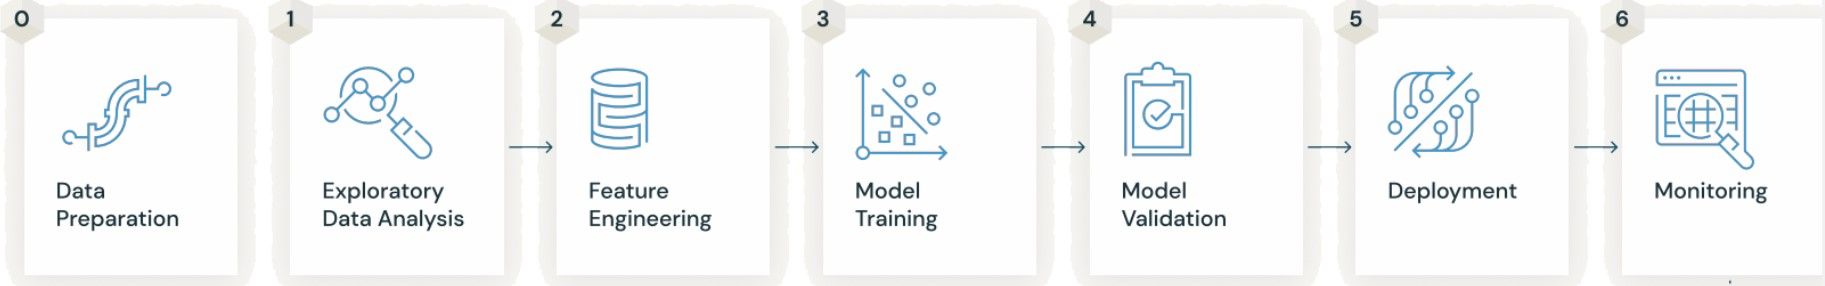

In [1]:
from IPython import display
display.Image(r"C:\Users\kherm\Documents\Openclassrooms\projet 7\pictures\mlflow_description.jpg")

MLflow est utilisé pour gérer le cycle de vie de l'apprentissage automatique, du développement initial du modèle au déploiement et au-delà jusqu'à l'extinction. Il combine :

1. Suivi des expériences ML pour enregistrer et comparer les paramètres du modèle, évaluer les performances et gérer les artefacts (MLflow Tracking)

2. Conditionnement du code ML sous une forme réutilisable et reproductible afin de le partager avec d'autres data scientists ou de le transférer en production (MLflow Projects)

3. Empaqueter et déployer des modèles à partir d'une variété de bibliothèques ML vers une variété de plates-formes de service et d'inférence de modèles (modèles MLflow)

4. Gestion collaborative d'un magasin de modèles central, y compris la gestion des versions des modèles, les transitions d'étape et les annotations (MLflow Registry)

5. Accélération du développement itératif avec des modèles et des scripts réutilisables pour une variété de tâches de modélisation courantes (MLflow Recipes)

In [2]:
!mlflow

Usage: mlflow [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  artifacts    Upload, list, and download artifacts from an MLflow...
  db           Commands for managing an MLflow tracking database.
  deployments  Deploy MLflow models to custom targets.
  doctor       Prints out useful information for debugging issues with MLflow.
  experiments  Manage experiments.
  gc           Permanently delete runs in the `deleted` lifecycle stage.
  models       Deploy MLflow models locally.
  recipes      Run MLflow Recipes and inspect recipe results.
  run          Run an MLflow project from the given URI.
  runs         Manage runs.
  sagemaker    Serve models on SageMaker.
  server       Run the MLflow tracking server.


In [2]:
#Importing libraries and setting the experiment
import mlflow
import mlflow.sklearn

#mlflow.set_experiment('LearnML-Demo')

In [3]:
!pip install imbalanced-learn

In [3]:
#Basic libraries
import pandas as pd
import seaborn as sns
import time, pickle
import numpy as np
from zipfile import ZipFile


#Metrics and models MLFLOW
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

#Operating system
import sys
import os

In [4]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\kherm\anaconda\envs\Scoring_projet\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [6]:
#MLFLow Metrics Evaluation
def eval_metrics(actual,pred):
    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae=mean_absolute_error(actual,pred)
    r2=r2_score(actual,pred)
    return rmse, mae, r2

# 1. Lecture des données 

In [7]:
#Reading the dataset
data_train_csv = pd.read_csv('data_train_sans_valeurs_manquantes.csv', index_col='SK_ID_CURR', encoding ='utf-8')
data_train=data_train_csv.copy()
data_train.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002               0.0          0.001512    0.090287     0.090032   
100003               0.0          0.002089    0.311736     0.132924   
100004               0.0          0.000358    0.022472     0.020025   
100006               0.0          0.000935    0.066837     0.109477   
100007               0.0          0.000819    0.116854     0.078975   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.111161   
100003             0.271605                    0.045016    0.522886   
100004             0.023569                    0.134897    0.651466   
100006             0.063973                    0.107023    0.649154   
100007             0.117845                    0.392880    0.701409   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
SK_ID_CURR                                                     ...   
100002           0.964437           0.852140         0.705433  ...   
100003           0.933676           0.951929         0.959566  ...   
100004           0.987439           0.827335         0.648326  ...   
100006           0.830337           0.601451         0.661387  ...   
100007           0.830393           0.825268         0.519522  ...   

            HOUSETYPE_MODE_terraced house  WALLSMATERIAL_MODE_Block  \
SK_ID_CURR                                                            
100002                                0.0                       0.0   
100003                                0.0                       1.0   
100004                                0.0                       0.0   
100006                                0.0                       0.0   
100007                                0.0                       0.0   

            WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
SK_ID_CURR                                                            
100002                           0.0                            0.0   
100003                           0.0                            0.0   
100004                           0.0                            0.0   
100006                           0.0                            0.0   
100007                           0.0                            0.0   

            WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
SK_ID_CURR                                                        
100002                            0.0                       0.0   
100003                            0.0                       0.0   
100004                            0.0                       0.0   
100006                            0.0                       0.0   
100007                            0.0                       0.0   

            WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  \
SK_ID_CURR                                                               
100002                                  1.0                        0.0   
100003                                  0.0                        0.0   
100004                                  0.0                        0.0   
100006                                  0.0                        0.0   
100007                                  0.0                        0.0   

            EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  
SK_ID_CURR                                                   
100002                         1.0                      0.0  
100003                         1.0                      0.0  
100004                         0.0                      0.0  
100006                         0.0                      0.0  
100007                         0.0                      0.0  

[5 rows x 312 columns]

In [8]:
data_train.shape

(307511, 312)

In [9]:
TARGET_csv=pd.read_csv('TARGET.csv',index_col='SK_ID_CURR')
TARGET=TARGET_csv.copy()
TARGET.head()

TARGET
SK_ID_CURR        
100002         1.0
100003         0.0
100004         0.0
100006         0.0
100007         0.0

In [10]:
TARGET.shape

(307511, 1)

### Merging both train and target 

In [11]:
final_data=pd.concat([data_train, TARGET], axis=1, join='inner')
final_data.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002               0.0          0.001512    0.090287     0.090032   
100003               0.0          0.002089    0.311736     0.132924   
100004               0.0          0.000358    0.022472     0.020025   
100006               0.0          0.000935    0.066837     0.109477   
100007               0.0          0.000819    0.116854     0.078975   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.111161   
100003             0.271605                    0.045016    0.522886   
100004             0.023569                    0.134897    0.651466   
100006             0.063973                    0.107023    0.649154   
100007             0.117845                    0.392880    0.701409   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
SK_ID_CURR                                                     ...   
100002           0.964437           0.852140         0.705433  ...   
100003           0.933676           0.951929         0.959566  ...   
100004           0.987439           0.827335         0.648326  ...   
100006           0.830337           0.601451         0.661387  ...   
100007           0.830393           0.825268         0.519522  ...   

            WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
SK_ID_CURR                                                       
100002                           0.0                       0.0   
100003                           1.0                       0.0   
100004                           0.0                       0.0   
100006                           0.0                       0.0   
100007                           0.0                       0.0   

            WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
SK_ID_CURR                                                             
100002                                0.0                        0.0   
100003                                0.0                        0.0   
100004                                0.0                        0.0   
100006                                0.0                        0.0   
100007                                0.0                        0.0   

            WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
SK_ID_CURR                                                              
100002                           0.0                              1.0   
100003                           0.0                              0.0   
100004                           0.0                              0.0   
100006                           0.0                              0.0   
100007                           0.0                              0.0   

            WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  \
SK_ID_CURR                                                      
100002                            0.0                     1.0   
100003                            0.0                     1.0   
100004                            0.0                     0.0   
100006                            0.0                     0.0   
100007                            0.0                     0.0   

            EMERGENCYSTATE_MODE_Yes  TARGET  
SK_ID_CURR                                   
100002                          0.0     1.0  
100003                          0.0     0.0  
100004                          0.0     0.0  
100006                          0.0     0.0  
100007                          0.0     0.0  

[5 rows x 313 columns]

# 2. Splitting des données

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 312), (92254, 312), (215257, 1), (92254, 1))

# 3. Baseline Model 

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [14]:
from sklearn.linear_model import LogisticRegression

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances,roc_auc):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances :
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

    #features = []
    #for i in range(20):
        #features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    #sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    #plt.xlabel('Features importance')
    #plt.xticks(rotation=90)

    show()

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
mlflow.set_experiment('Linear-Regression')

<Experiment: artifact_location='file:///C:/Users/kherm/mlruns/564260440075886882', creation_time=1690534775217, experiment_id='564260440075886882', last_update_time=1690534775217, lifecycle_stage='active', name='Linear-Regression', tags={}>

In [18]:
#MLFLow Model function Linear Regression
def train_lr_model(C,max_iter,data):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    train_x=train.drop(["TARGET"],axis=1)
    test_x=test.drop(["TARGET"],axis=1)
    train_y=train[["TARGET"]]
    test_y=test[["TARGET"]]
    
    
    with mlflow.start_run():
        
        lr = LogisticRegression(C=C,max_iter=max_iter)
        lr.fit(train_x,train_y)
        
        predicted_qualities=lr.predict(test_x)
        
        (rmse,mae,r2)=eval_metrics(test_y,predicted_qualities)
        print("ElasticNet model (C=%f,max_iter=%f):" % (C,max_iter))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        
        roc_auc = roc_auc_score(test_y, lr.predict_proba(test_x)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(test_y, lr.predict(test_x)))
        cf_matrix_roc_auc(lr, test_y, lr.predict(test_x), lr.predict_proba(test_x)[:,1], feature_importances=None,roc_auc=roc_auc)
        
        mlflow.log_param("C",C)
        mlflow.log_param("max_iter",max_iter)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(lr,"model")

ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.28346823346289474
 MAE:0.0803542393825742
 R2:-0.08737520774154017
AUC : 0.7371
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



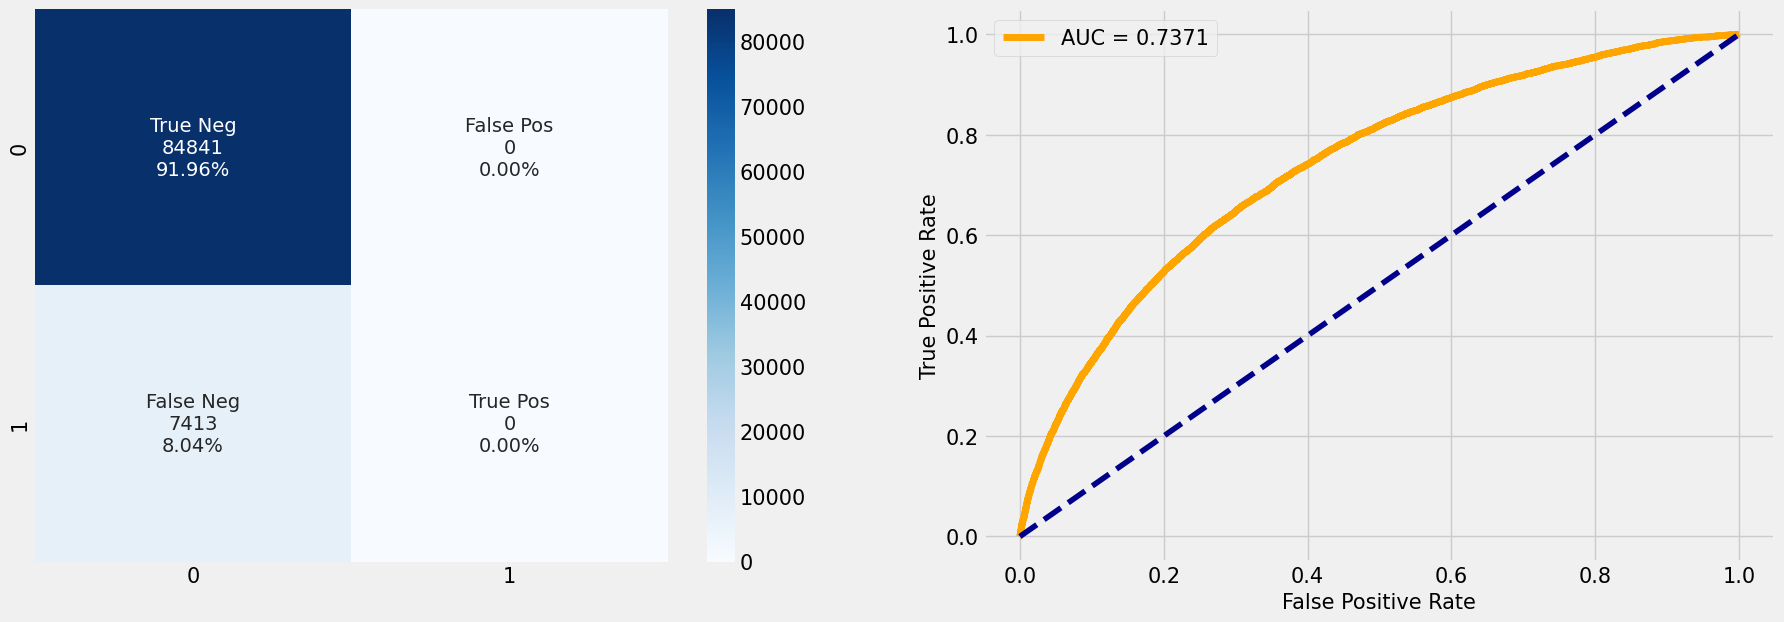

In [19]:
train_lr_model(0.001,100,final_data)

ElasticNet model (C=0.002000,max_iter=100.000000):
 RMSE: 0.2834873524885438
 MAE:0.08036507902096386
 R2:-0.08752189264748123
AUC : 0.7442
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.40      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.66      0.50      0.48     92254
weighted avg       0.88      0.92      0.88     92254



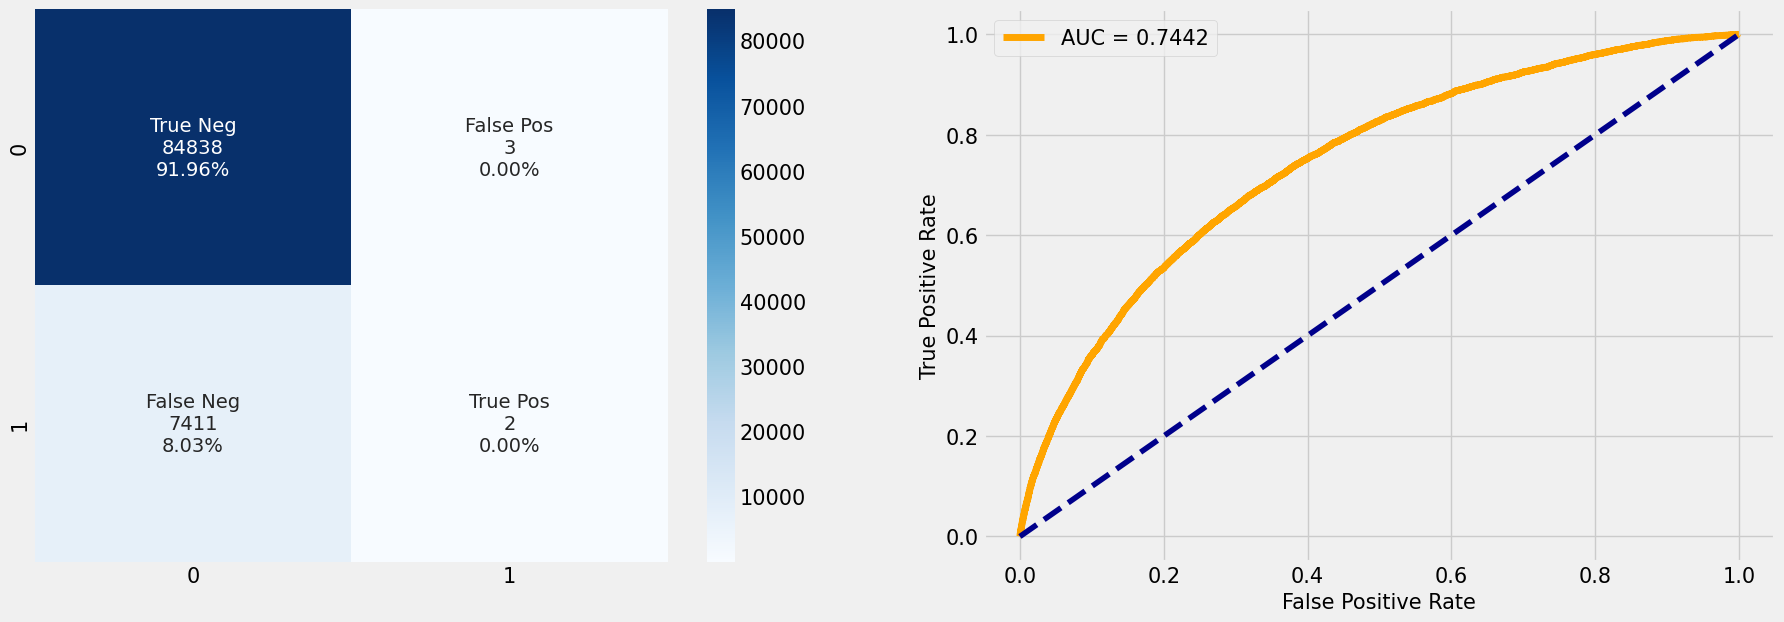

In [21]:
train_lr_model(0.002,100,final_data)

ElasticNet model (C=0.100000,max_iter=100.000000):
 RMSE: 0.28306643562314354
 MAE:0.08012660697639126
 R2:-0.08429482471677652
AUC : 0.7558
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.55      0.02      0.03      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254



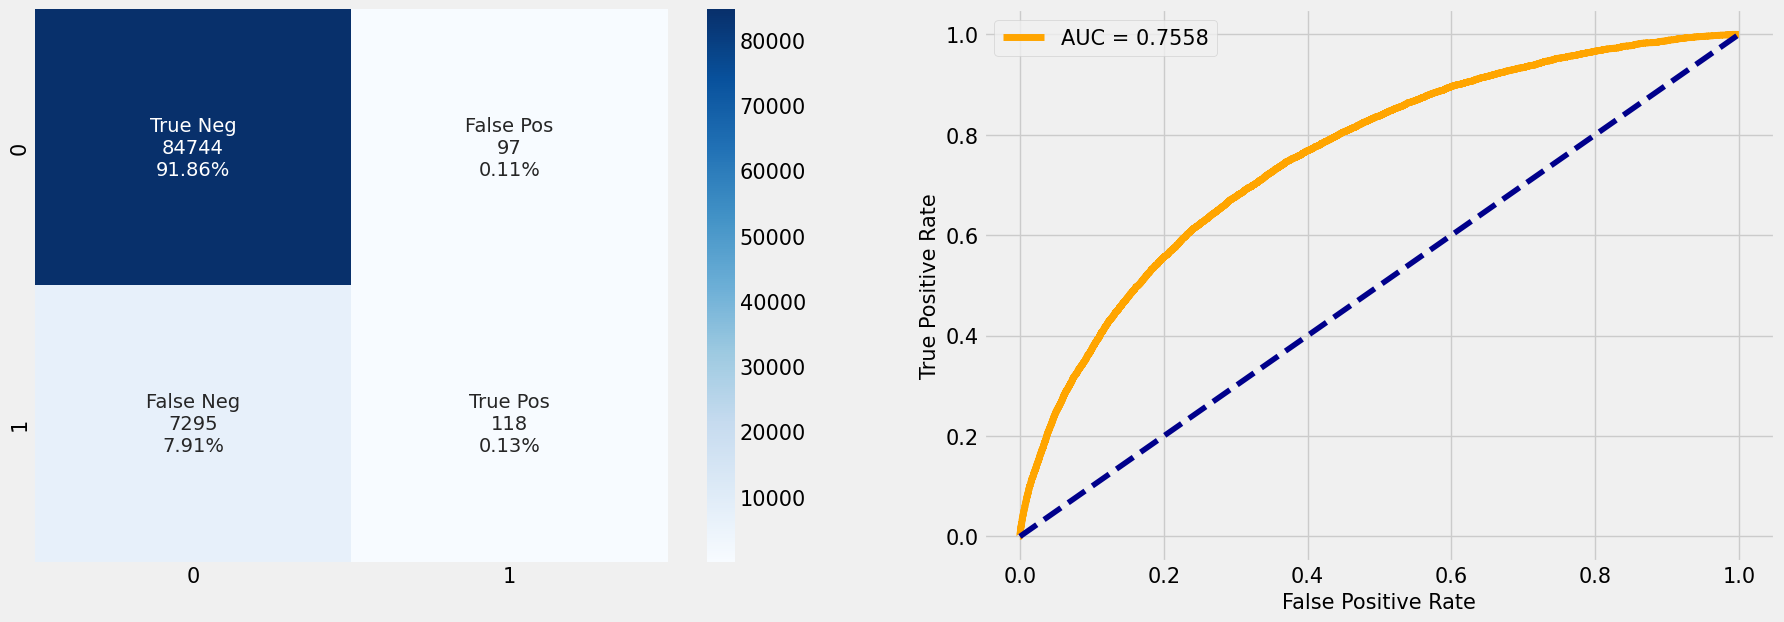

In [22]:
train_lr_model(0.1,100,final_data)

ElasticNet model (C=1.000000,max_iter=100.000000):
 RMSE: 0.2830855817854045
 MAE:0.08013744661478094
 R2:-0.08444150962271779
AUC : 0.7560
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.54      0.02      0.04      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.51      0.50     92254
weighted avg       0.89      0.92      0.88     92254



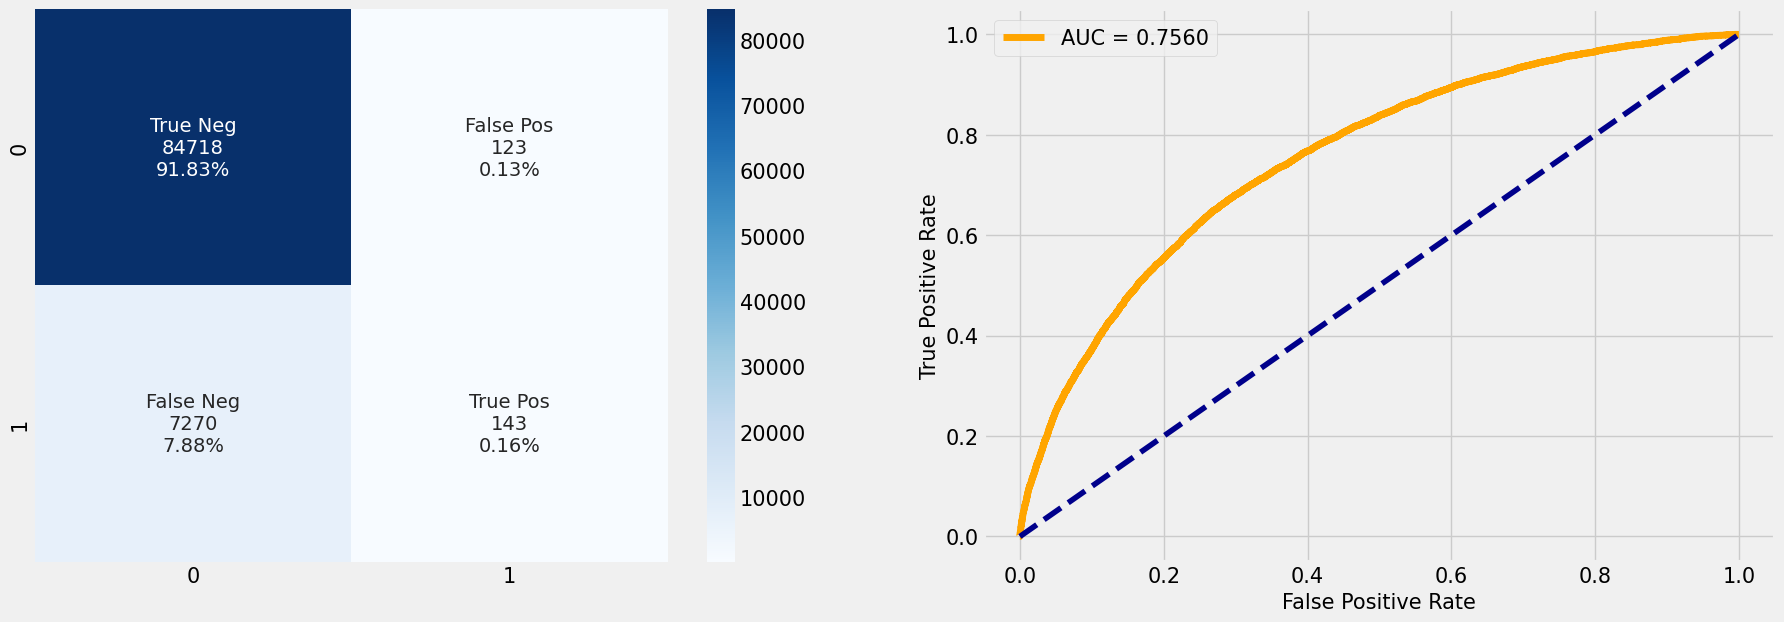

In [23]:
train_lr_model(1.0,100,final_data)

ElasticNet model (C=1.000000,max_iter=10000.000000):
 RMSE: 0.2832195686803943
 MAE:0.08021332408350858
 R2:-0.0854683039643056
AUC : 0.7578
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.52      0.02      0.04      7413

    accuracy                           0.92     92254
   macro avg       0.72      0.51      0.50     92254
weighted avg       0.89      0.92      0.88     92254



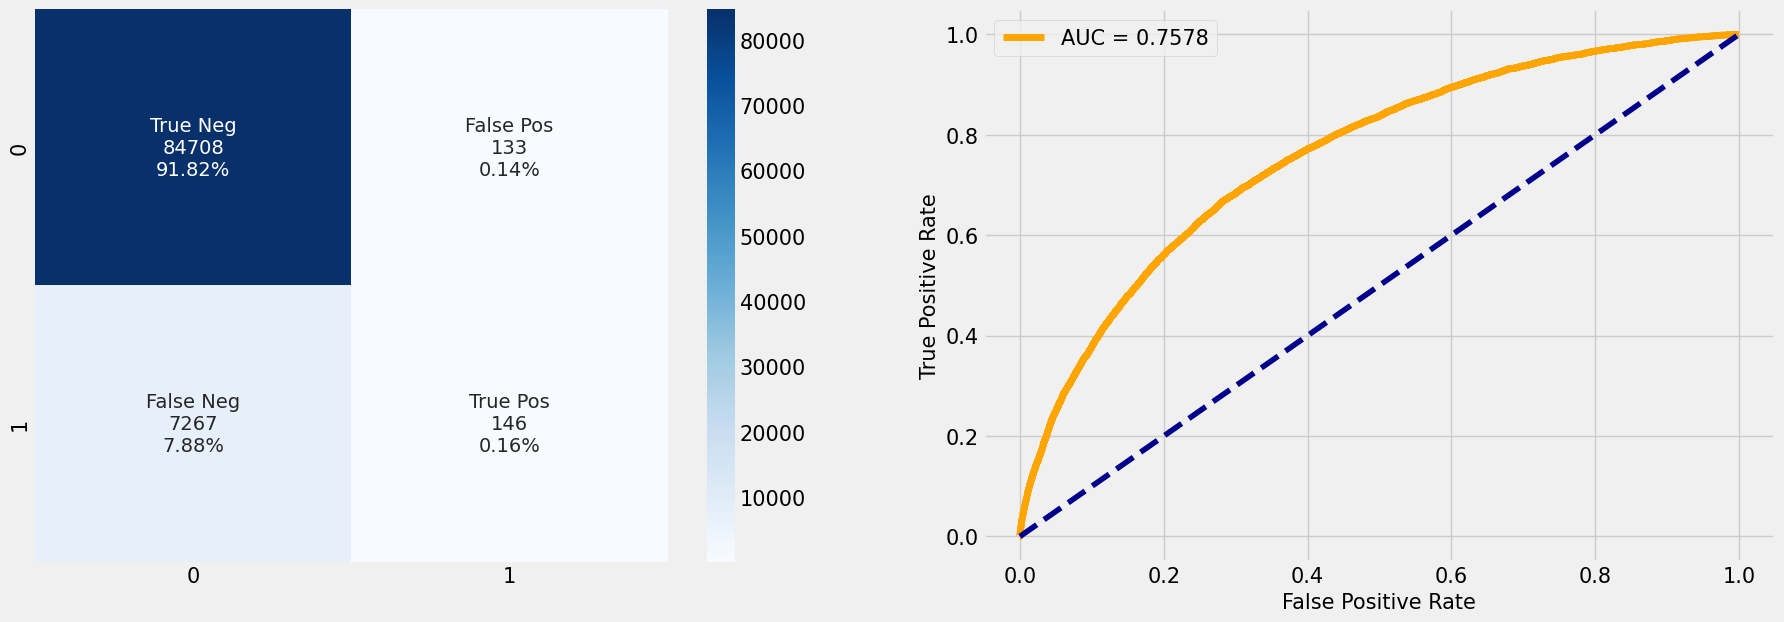

In [24]:
train_lr_model(1.0,10000,final_data)

In [25]:
mlflow.end_run()

In [26]:
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6943
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



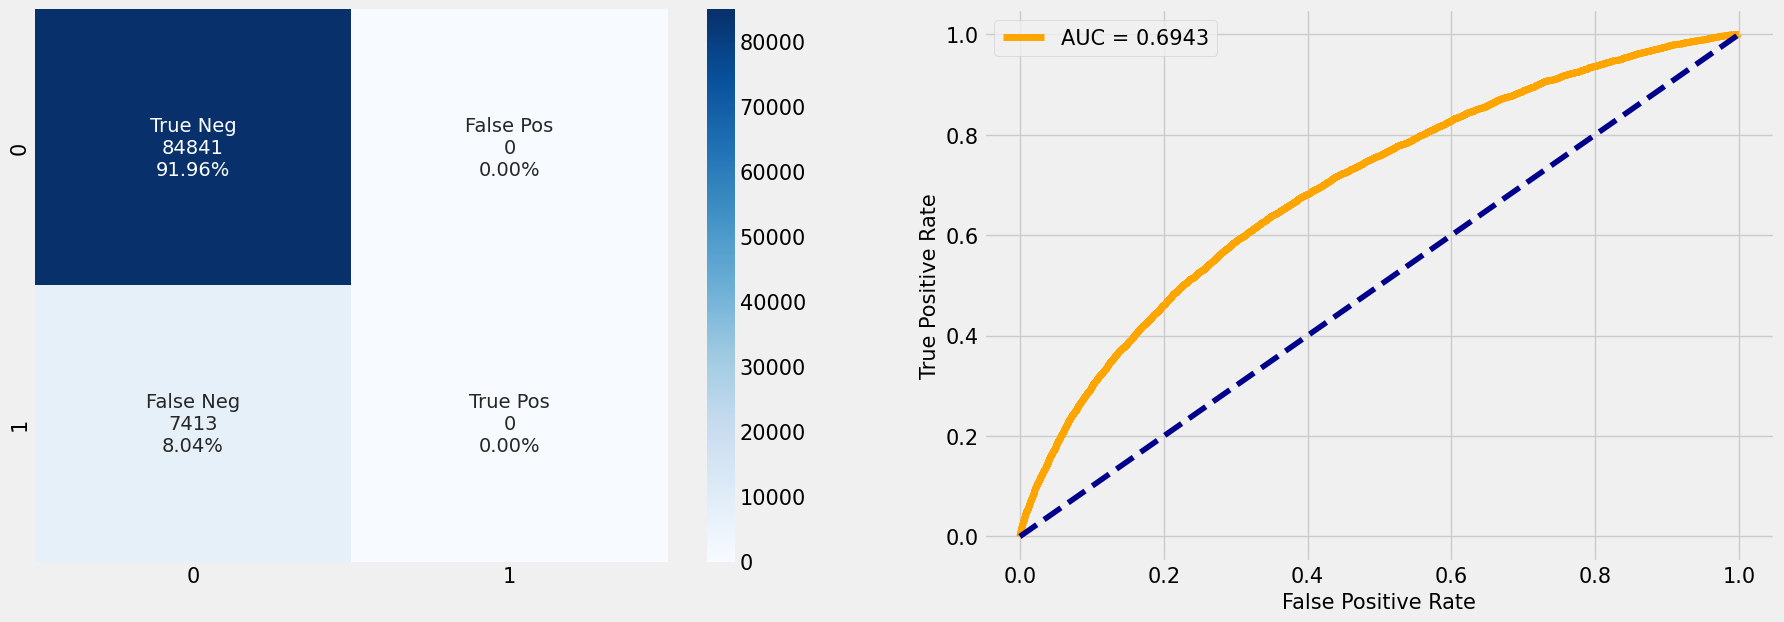

In [29]:
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)

### Conclusion

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 ( environ 0.92) et la Target 1 (0.08). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit.

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

# 4. Oversampling Data Using SMOTE
SMOTE with Imbalance Data using imblearn module

In [16]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [17]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [18]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


### Preparing SMOTE DATA

In [19]:
X_train_smote=X_train_res
y_train_smote=y_train_res

In [20]:
mlflow.set_experiment('Linear-Regression-SMOTE')

<Experiment: artifact_location='file:///C:/Users/kherm/mlruns/988344523285977687', creation_time=1691064802979, experiment_id='988344523285977687', last_update_time=1691064802979, lifecycle_stage='active', name='Linear-Regression-SMOTE', tags={}>

In [21]:
#MLFLow Model function Linear Regression
def train_lr_model_smote(C,max_iter,data,X_train_smote,y_train_smote):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    train_x=X_train_smote
    test_x=test.drop(["TARGET"],axis=1)
    train_y=y_train_smote
    test_y=test[["TARGET"]]
    
    
    with mlflow.start_run():
        
        lr = LogisticRegression(C=C,max_iter=max_iter)
        lr.fit(train_x,train_y)
        
        predicted_qualities=lr.predict(test_x)
        
        (rmse,mae,r2)=eval_metrics(test_y,predicted_qualities)
        print("ElasticNet model (C=%f,max_iter=%f):" % (C,max_iter))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        
        roc_auc = roc_auc_score(test_y, lr.predict_proba(test_x)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(test_y, lr.predict(test_x)))
        cf_matrix_roc_auc(lr, test_y, lr.predict(test_x), lr.predict_proba(test_x)[:,1], feature_importances=None,roc_auc=roc_auc)
        
        mlflow.log_param("C",C)
        mlflow.log_param("max_iter",max_iter)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(lr,"model")

ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.5530577872876573
 MAE:0.3058729160795196
 R2:-3.1391546758465907
AUC : 0.7408
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84841
         1.0       0.16      0.66      0.26      7413

    accuracy                           0.69     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.89      0.69      0.76     92254



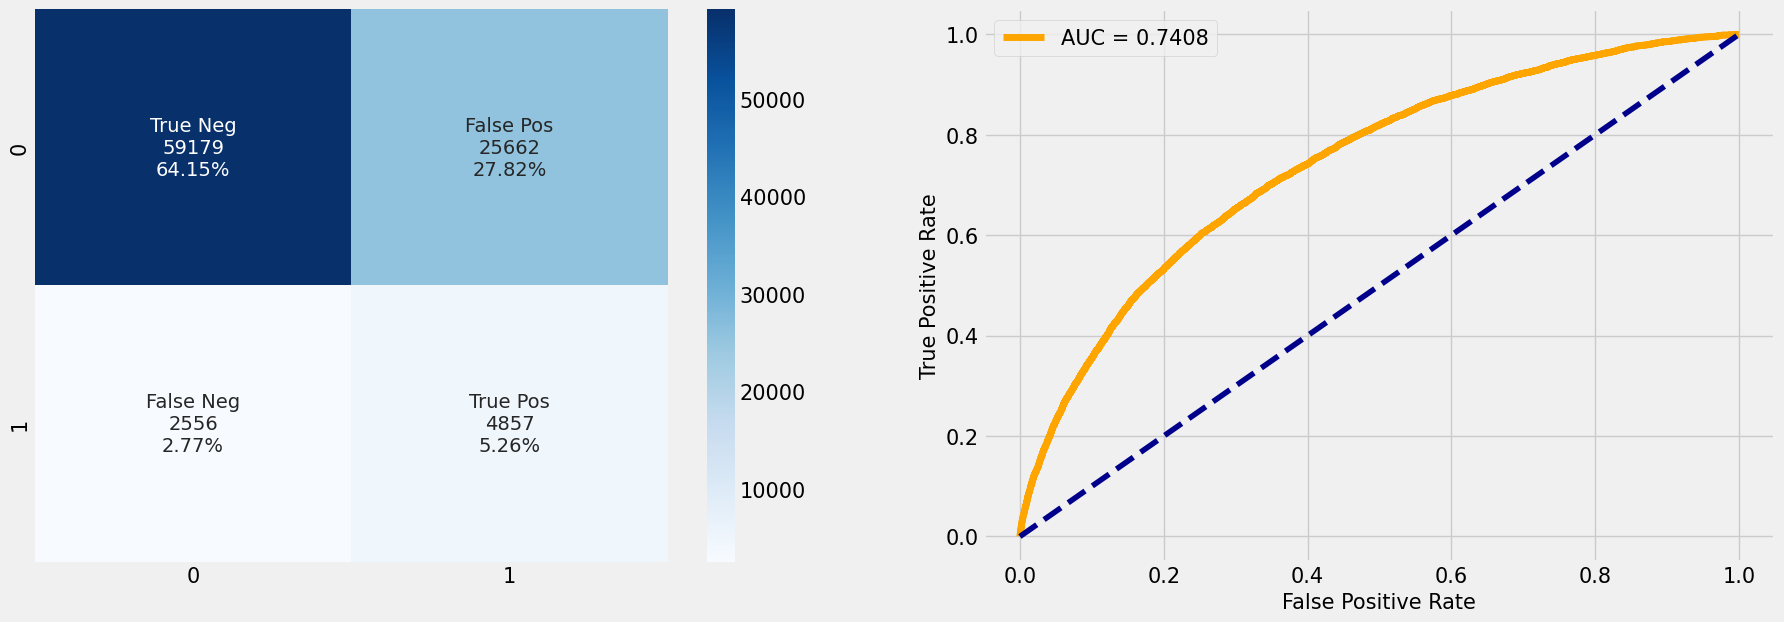

In [22]:
train_lr_model_smote(0.001,100,final_data,X_train_smote,y_train_smote)

ElasticNet model (C=1.000000,max_iter=100.000000):
 RMSE: 0.547720578463437
 MAE:0.29999783207232206
 R2:-3.0596514568265025
AUC : 0.7454
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84841
         1.0       0.16      0.65      0.26      7413

    accuracy                           0.70     92254
   macro avg       0.56      0.68      0.54     92254
weighted avg       0.89      0.70      0.77     92254



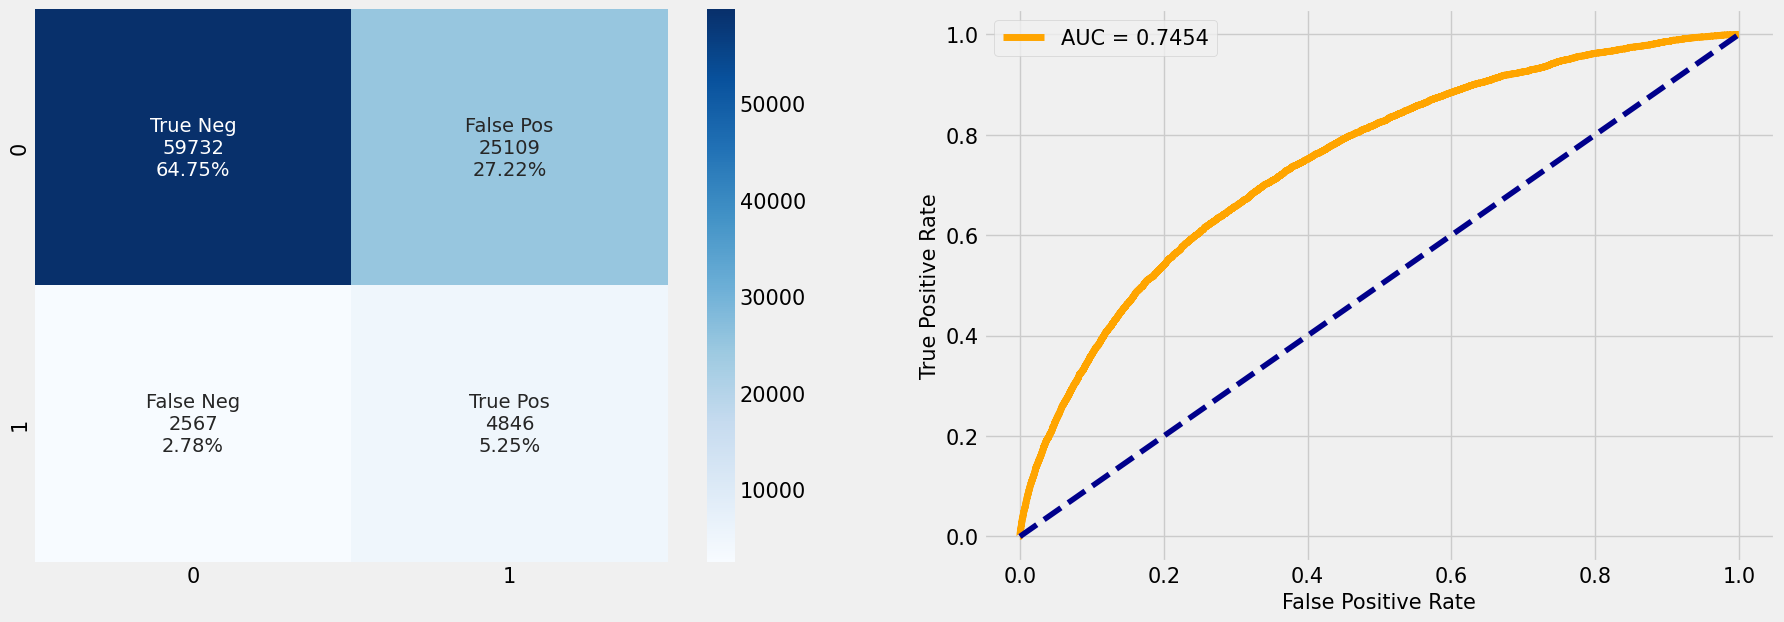

In [23]:
train_lr_model_smote(1.0,100,final_data,X_train_smote,y_train_smote)  

In [24]:
mlflow.end_run()

In [37]:
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7188
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.51     92254
weighted avg       0.89      0.67      0.74     92254



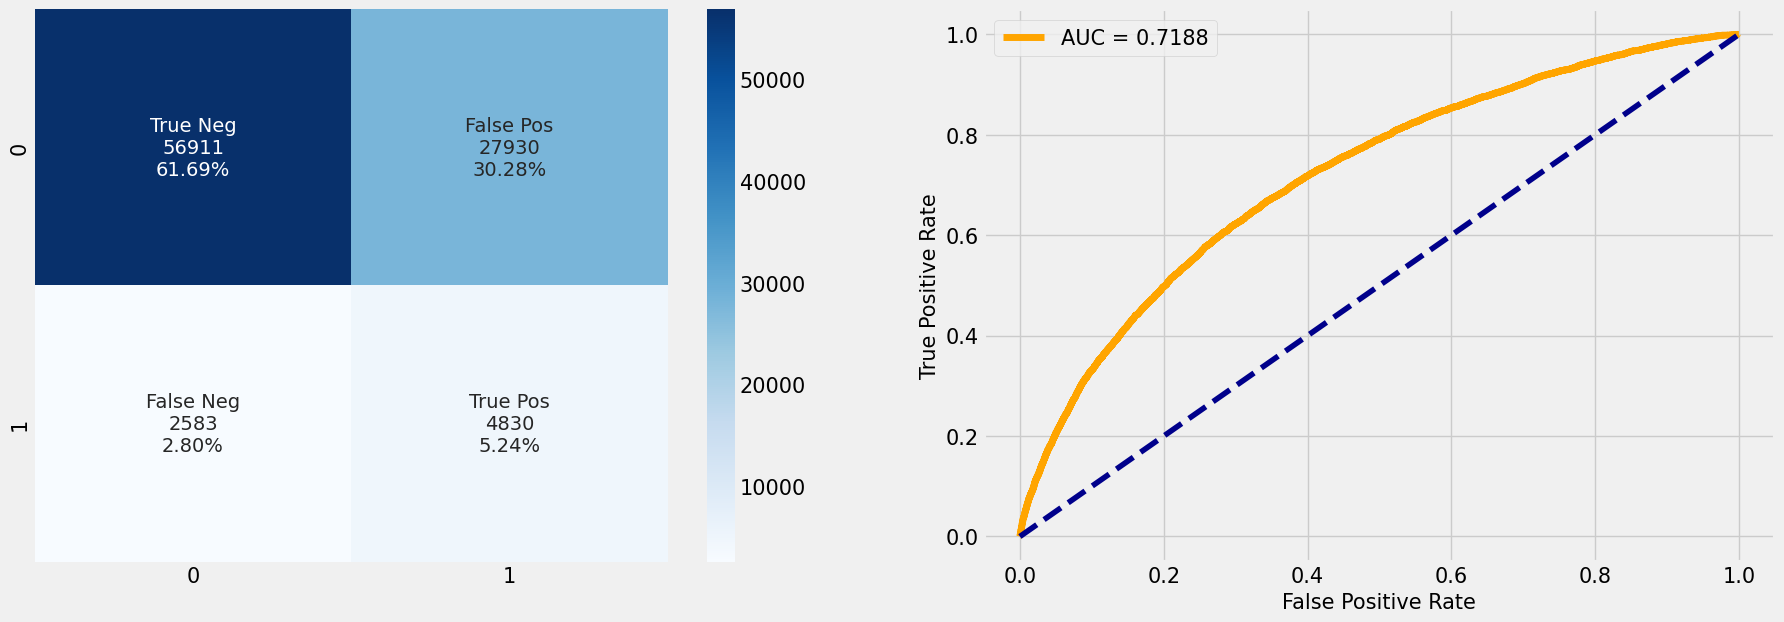

In [38]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)


Amélioration de l'AUC score 0.75 que nous prendrons comme baseline de travail pour la suite des essais. 

# 5. Gradient Boosting 

On utilisera les modèles : Catboost, Lightgbm et XGBoost en Classifier. 

In [25]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [29]:
mlflow.set_experiment('Gradient-Boosting-models')

<Experiment: artifact_location='file:///C:/Users/kherm/mlruns/490127364567853384', creation_time=1691069085378, experiment_id='490127364567853384', last_update_time=1691069085378, lifecycle_stage='active', name='Gradient-Boosting-models', tags={}>

## Données sans équilibrage

In [27]:
from sklearn import metrics

In [28]:
def train_model(model,data):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    X_train=train.drop(["TARGET"],axis=1)
    X_test=test.drop(["TARGET"],axis=1)
    y_train=train[["TARGET"]]
    y_test=test[["TARGET"]]
    
    
    with mlflow.start_run():
        
        trained_model=model.fit(X_train, y_train)
        predicted_qualities=trained_model.predict(X_test)
    
        #Evaluation metrics
        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        accuracy=accuracy_score(y_test, predicted_qualities)
        precision=precision_score(y_test,predicted_qualities)
        recall=recall_score(y_test,predicted_qualities)
        f_one=metrics.f1_score(y_test,predicted_qualities)
        
        #print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)
        
     
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("F-1 score",f_one)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(model,"model")

 RMSE: 0.28254899883006196
 MAE:0.07983393673987035
 R2:-0.08033433225636633
 Accuracy: 0.9201660632601296
 Precision:0.56
 Recall:0.030217186024551465
 F-1 Score: 0.05734033021886599
AUC : 0.7758
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.56      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



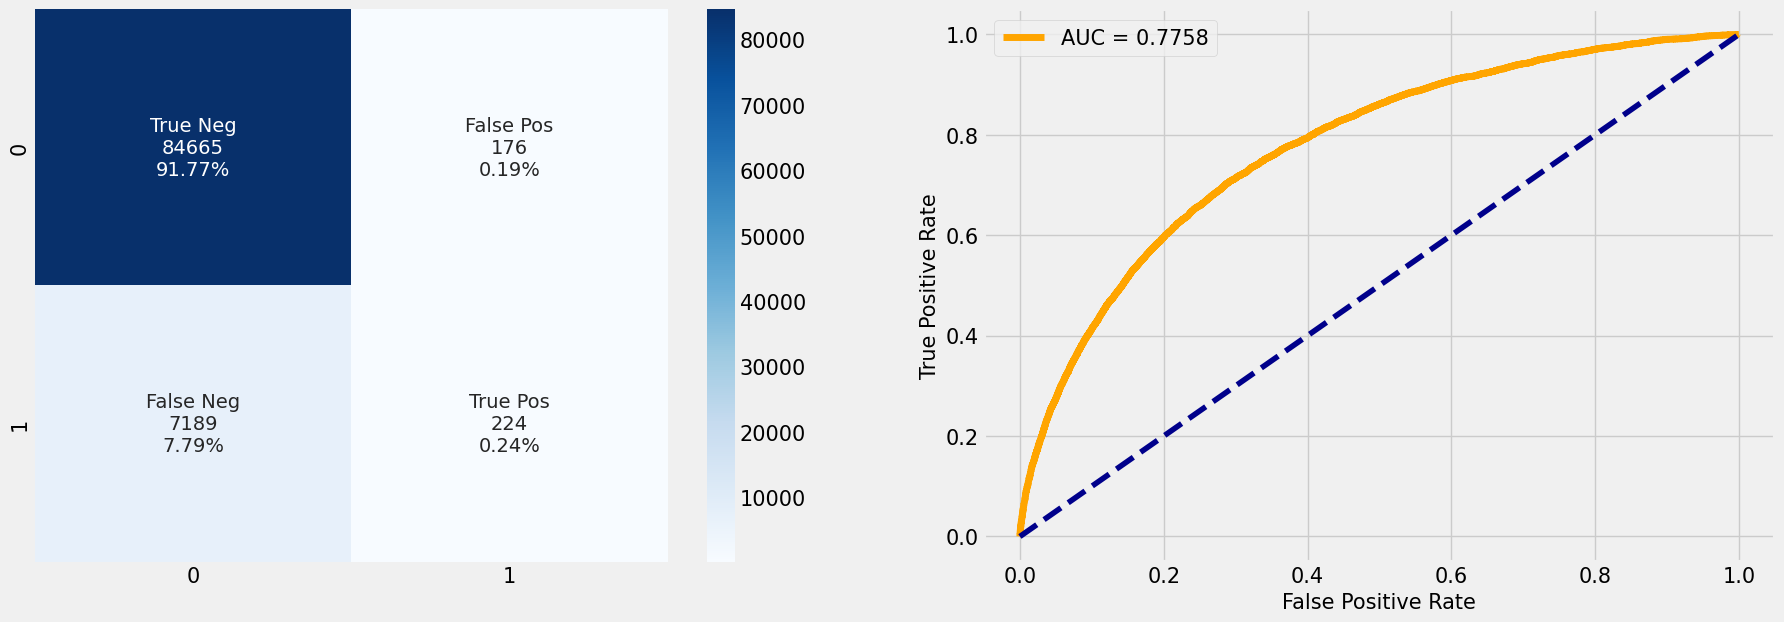

In [86]:
train_model(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data)

In [33]:
import re
final_data_light=final_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

 RMSE: 0.28295153144320195
 MAE:0.0800615691460533
 R2:-0.08341471528112976
 Accuracy: 0.9199384308539467
 Precision:0.530751708428246
 Recall:0.03143126939160933
 F-1 Score: 0.05934793683138054
AUC : 0.7738
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.53      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



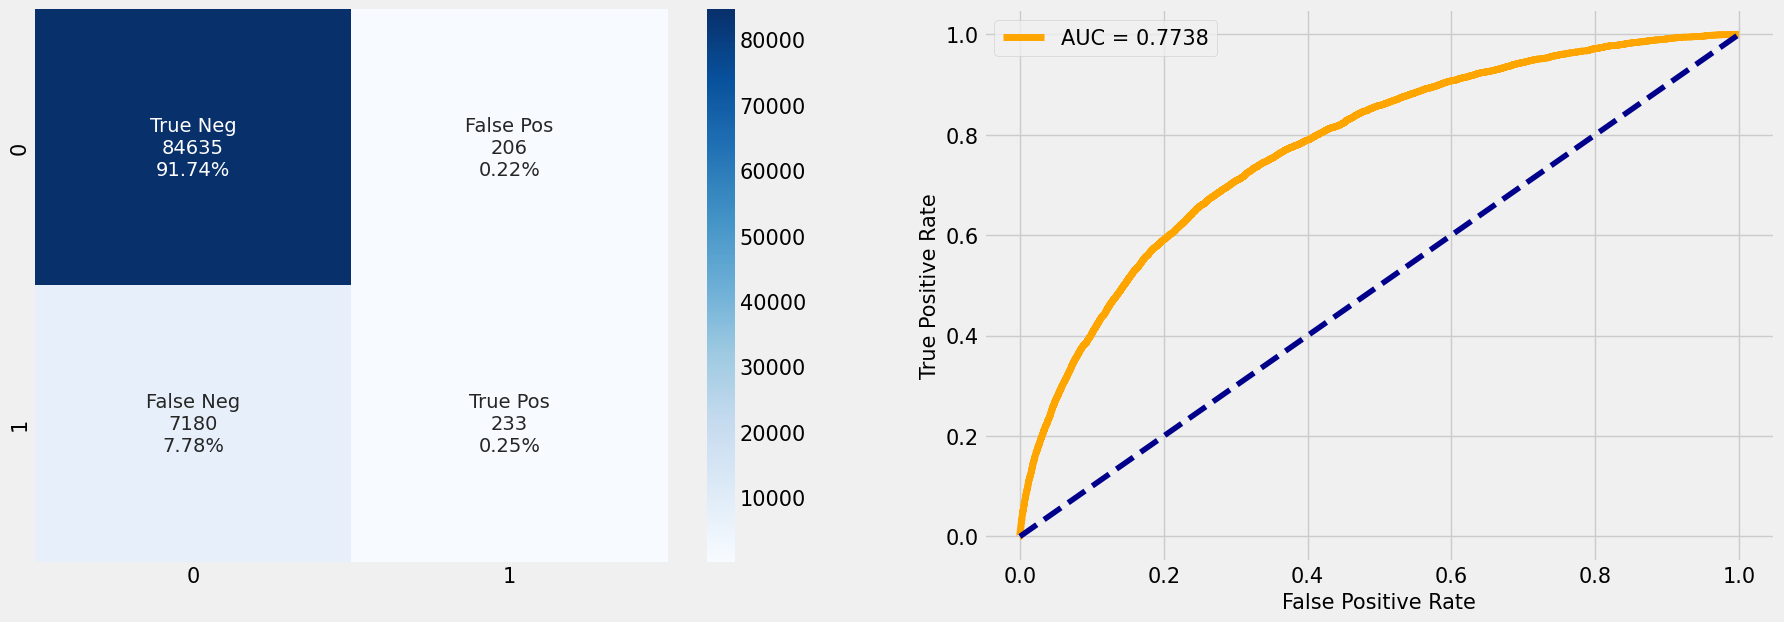

In [92]:
light_boost=LGBMClassifier(device='gpu')
train_model(light_boost,final_data_light)

 RMSE: 0.2851648070839988
 MAE:0.08131896719925423
 R2:-0.10043016437030006
 Accuracy: 0.9186810328007458
 Precision:0.4499437570303712
 Recall:0.05395926075812761
 F-1 Score: 0.0963623223319682
AUC : 0.7671
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.45      0.05      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.69      0.52      0.53     92254
weighted avg       0.89      0.92      0.89     92254



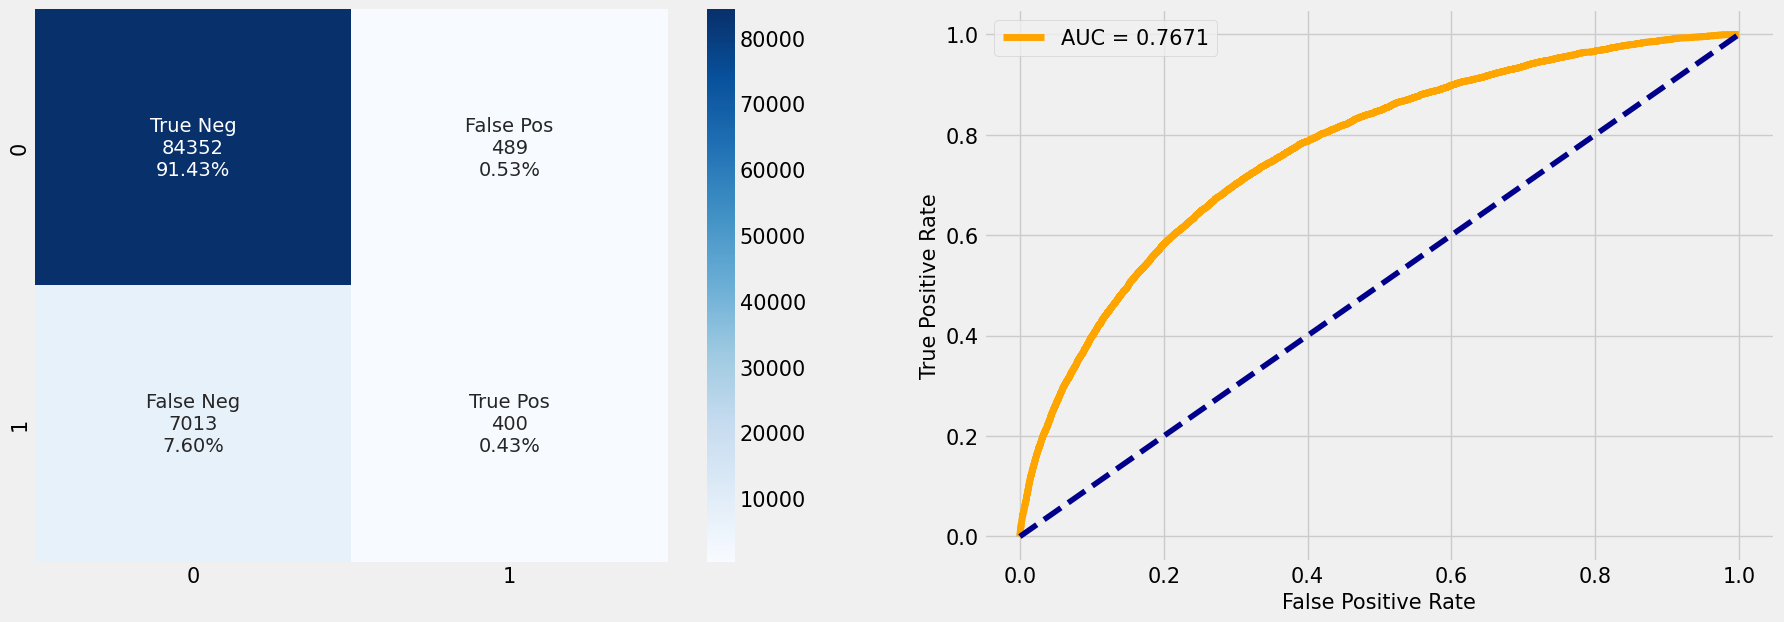

In [93]:
train_model(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data)

### Showing results here

In [37]:
models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]

La fonction suivante train_models peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux Scoring de Classification de Scikit-learn.

In [39]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': metrics.f1_score(y_test, model.predict(X_test),average='weighted')
      }

    return output

In [99]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    final_data_light=final_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train,test=train_test_split(final_data_light,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    X_train=train.drop(["TARGET"],axis=1)
    X_test=test.drop(["TARGET"],axis=1)
    y_train=train[["TARGET"]]
    y_test=test[["TARGET"]]
    
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 1min 25s
Wall time: 37.2 s


In [100]:
base_models

Model       AUC  Accuracy Precision    Recall        F1  \
0  CatBoostClassifier  0.775818  0.920166      0.56  0.030217   0.05734   
1      LGBMClassifier  0.773816  0.919938  0.530752  0.031431  0.059348   
2       XGBClassifier   0.76713  0.918681  0.449944  0.053959  0.096362   

        Time  
0  16.268135  
1  11.755588  
2   9.122981

Le LightGBM et Le Catboost ont un AUC plus élevé de 0.77. Cependant le Lightboost est beaucoup plus rapide. 

### Performance des algorithmes avec scale_pos_weight pour l'équilibrage des données 

lien : https://www.kaggle.com/code/kaanboke/xgboost-lightgbm-catboost-imbalanced-data

 RMSE: 0.30581759273464815
 MAE:0.09352440002601513
 R2:-0.2655973684600039
 Accuracy: 0.9064755999739849
 Precision:0.3614595210946408
 Recall:0.21381357075408067
 F-1 Score: 0.2686896084082048
AUC : 0.7771
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     84841
         1.0       0.36      0.21      0.27      7413

    accuracy                           0.91     92254
   macro avg       0.65      0.59      0.61     92254
weighted avg       0.89      0.91      0.90     92254



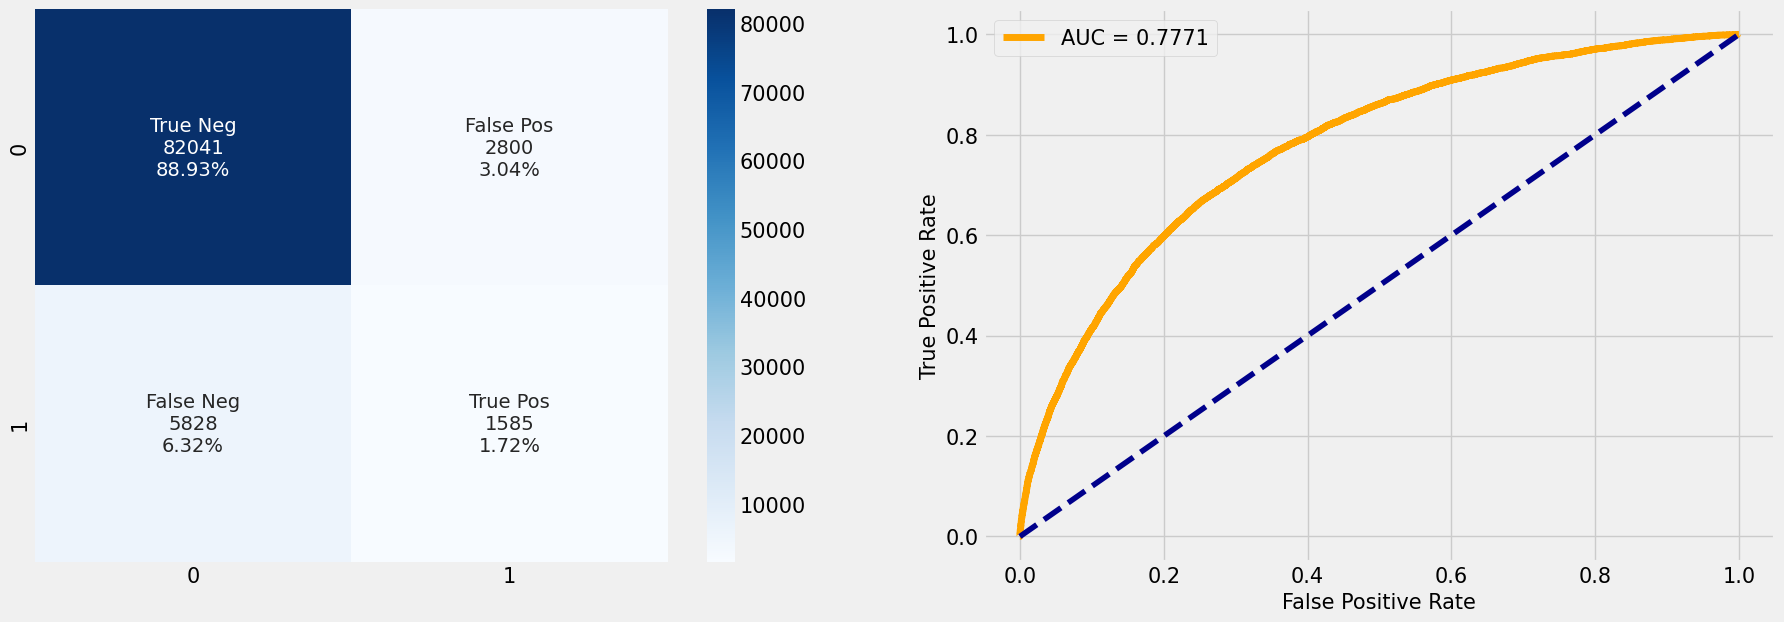

In [102]:
#Catboost with scale_pos_weight 3
train_model(CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=3),final_data)

 RMSE: 0.30813047991891523
 MAE:0.09494439265506102
 R2:-0.2848130911382909
 Accuracy: 0.905055607344939
 Precision:0.3543290043290043
 Recall:0.22082827465263727
 F-1 Score: 0.27208509931023017
AUC : 0.7761
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     84841
         1.0       0.35      0.22      0.27      7413

    accuracy                           0.91     92254
   macro avg       0.64      0.59      0.61     92254
weighted avg       0.89      0.91      0.89     92254



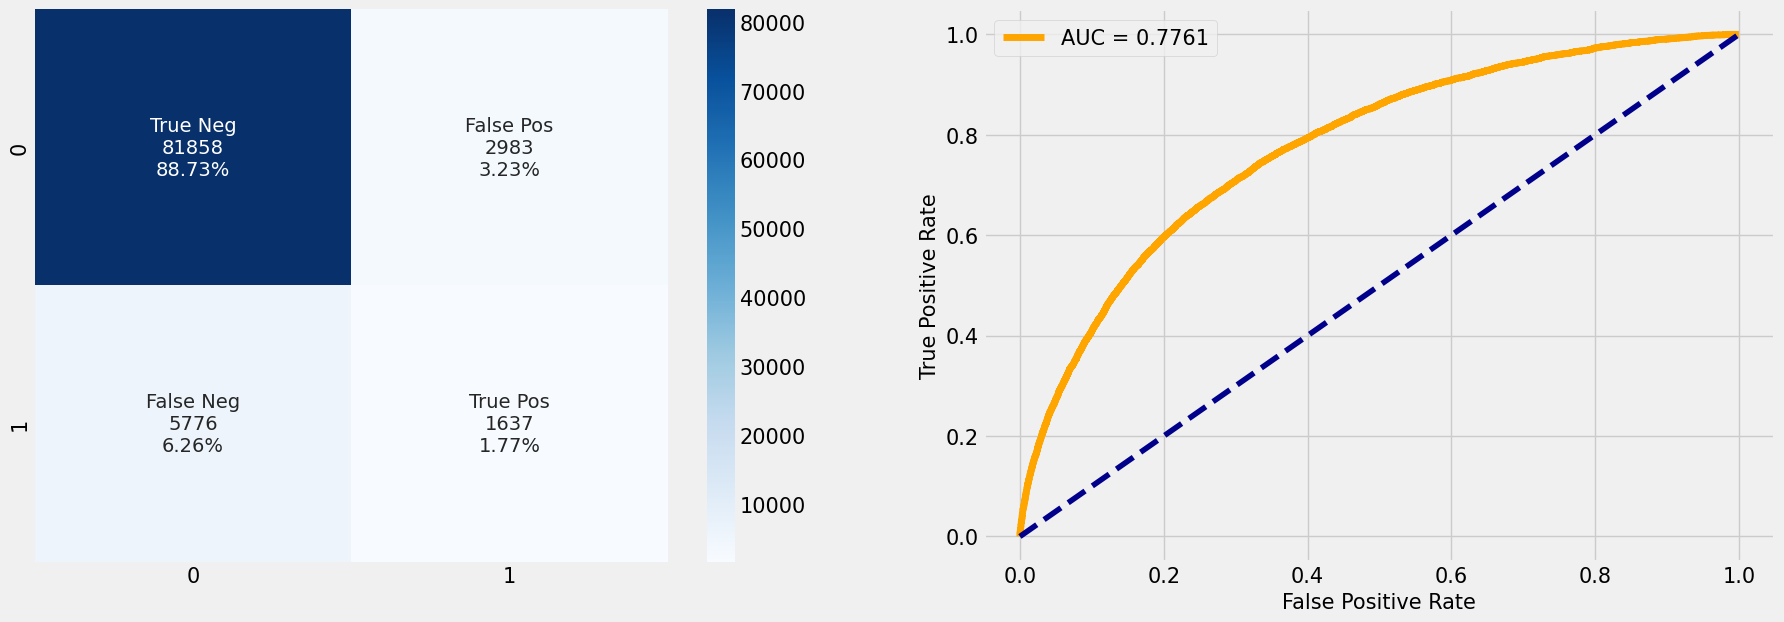

In [103]:
#LBoost with scale_pos_weight_3
light_boost=LGBMClassifier(device='gpu',scale_pos_weight=3)
train_model(light_boost,final_data_light)

 RMSE: 0.31484677713686554
 MAE:0.09912849307347107
 R2:-0.341433464831564
 Accuracy: 0.900871506926529
 Precision:0.3279014308426073
 Recall:0.2225819506272764
 F-1 Score: 0.265166733627963
AUC : 0.7636
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     84841
         1.0       0.33      0.22      0.27      7413

    accuracy                           0.90     92254
   macro avg       0.63      0.59      0.61     92254
weighted avg       0.89      0.90      0.89     92254



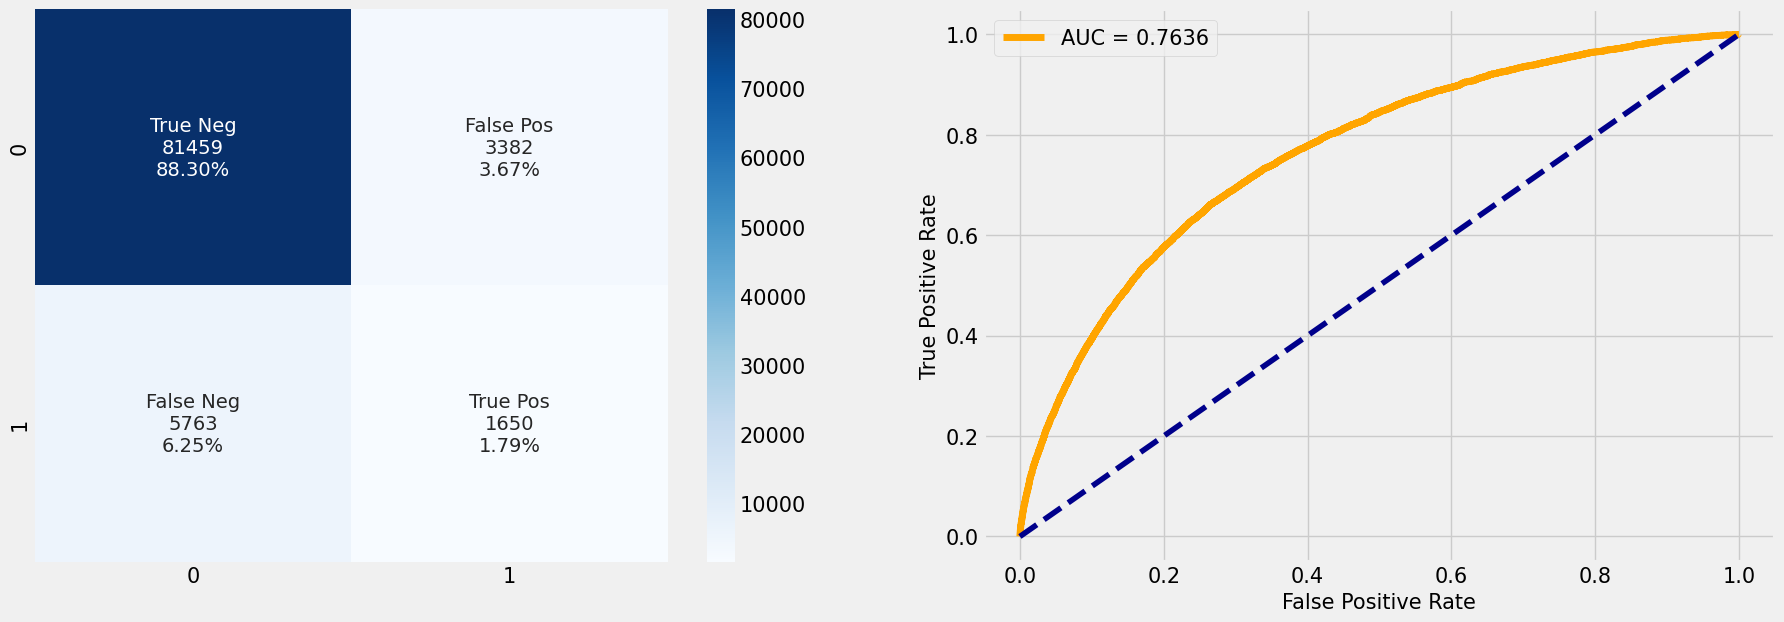

In [104]:
# XGBClassifier scale pos weight 3
train_model(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=3),final_data)

 RMSE: 0.3576115961783788
 MAE:0.12788605372124787
 R2:-0.7305885202933617
 Accuracy: 0.8721139462787522
 Precision:0.2816017531626656
 Recall:0.3813570754080669
 F-1 Score: 0.3239743295897318
AUC : 0.7777
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     84841
         1.0       0.28      0.38      0.32      7413

    accuracy                           0.87     92254
   macro avg       0.61      0.65      0.63     92254
weighted avg       0.89      0.87      0.88     92254



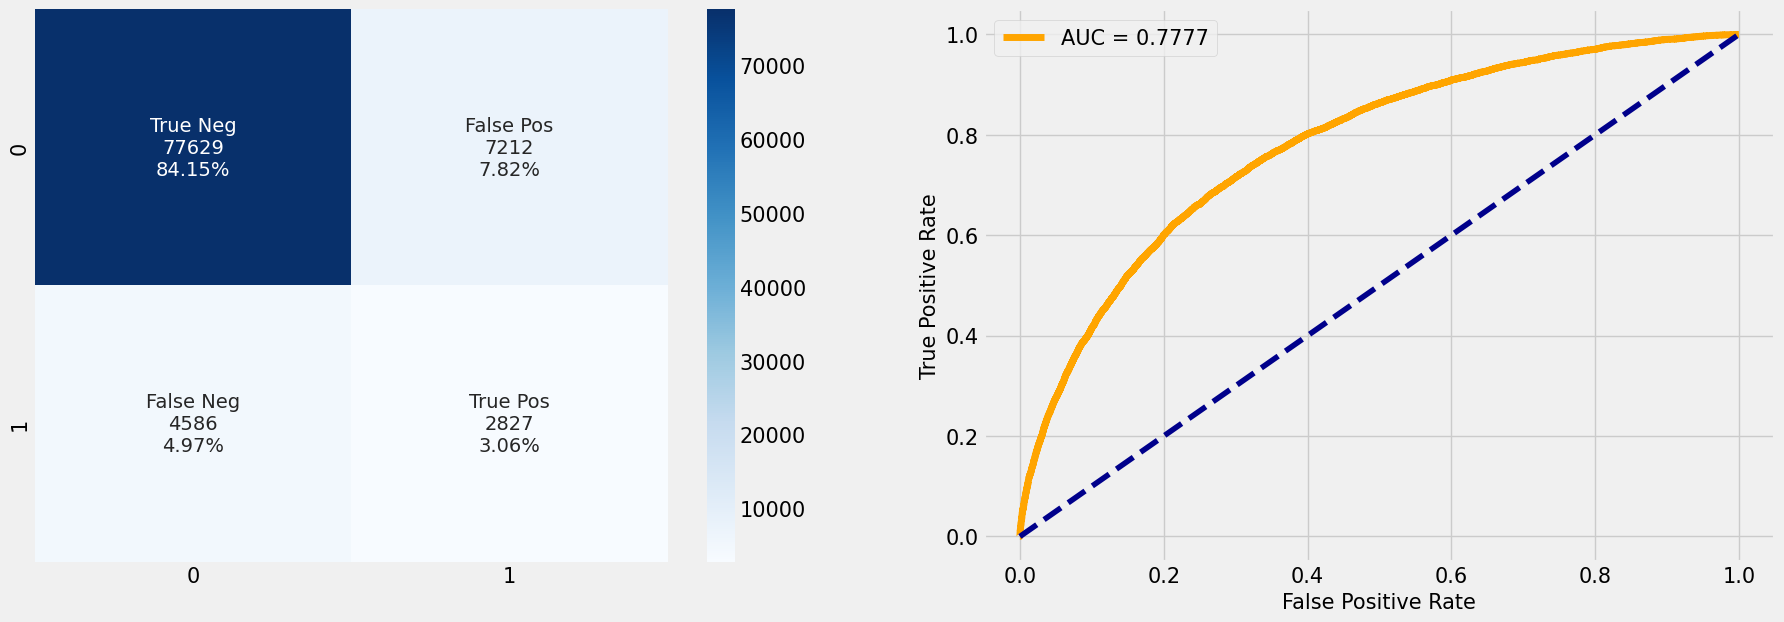

In [105]:
#Catboost with scale_pos_weight 5
train_model(CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=5),final_data)

 RMSE: 0.36727164350242225
 MAE:0.13488846012097036
 R2:-0.8253469695313269
 Accuracy: 0.8651115398790297
 Precision:0.2688596894238721
 Recall:0.3947119924457035
 F-1 Score: 0.31985133362483603
AUC : 0.7762
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     84841
         1.0       0.27      0.39      0.32      7413

    accuracy                           0.87     92254
   macro avg       0.61      0.65      0.62     92254
weighted avg       0.89      0.87      0.88     92254



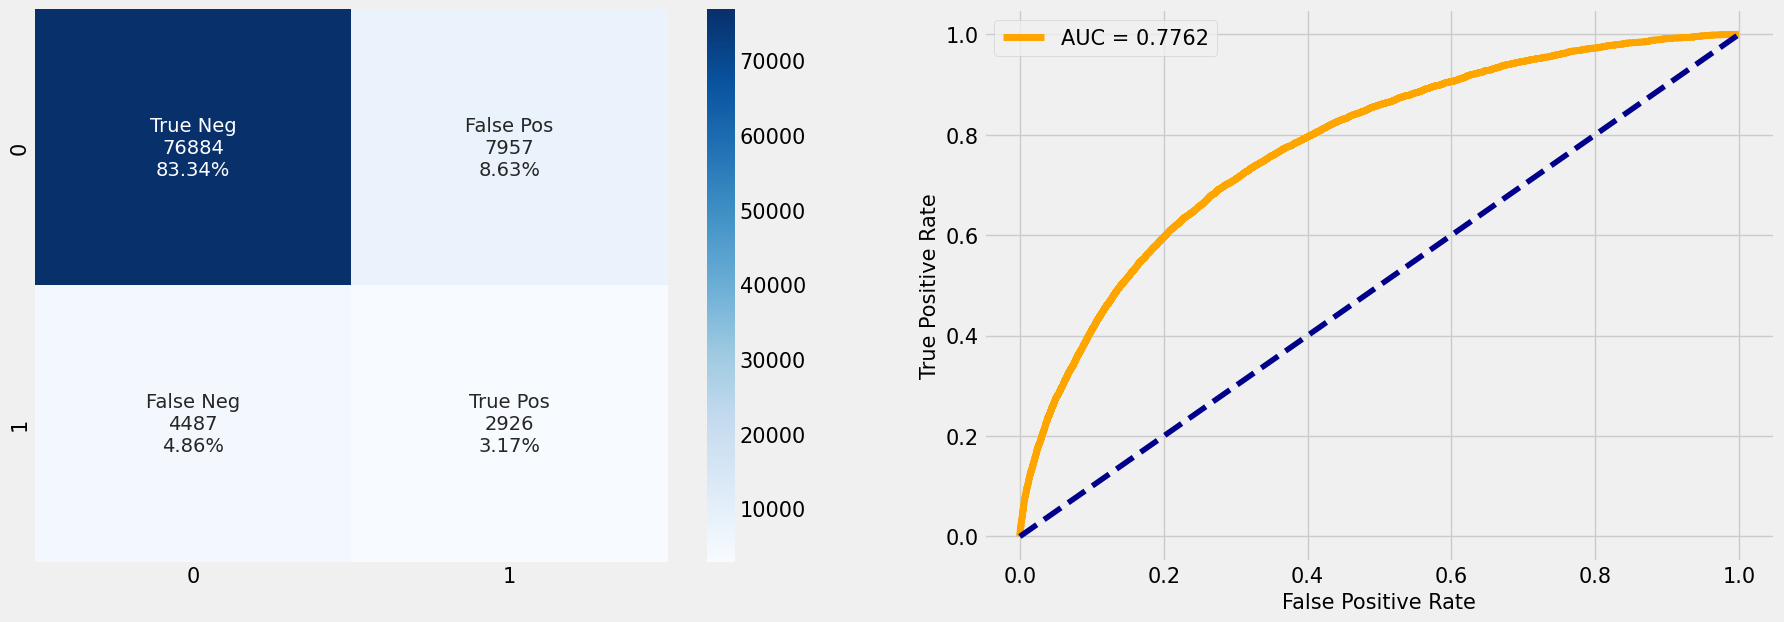

In [106]:
#LBoost with scale_pos_weight_5
light_boost=LGBMClassifier(device='gpu',scale_pos_weight=5)
train_model(light_boost,final_data_light)

 RMSE: 0.36126063473833736
 MAE:0.1305092462115464
 R2:-0.7660862675311133
 Accuracy: 0.8694907537884536
 Precision:0.26647824770364387
 Recall:0.35613112100364225
 F-1 Score: 0.3048498845265589
AUC : 0.7625
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     84841
         1.0       0.27      0.36      0.30      7413

    accuracy                           0.87     92254
   macro avg       0.60      0.64      0.62     92254
weighted avg       0.89      0.87      0.88     92254



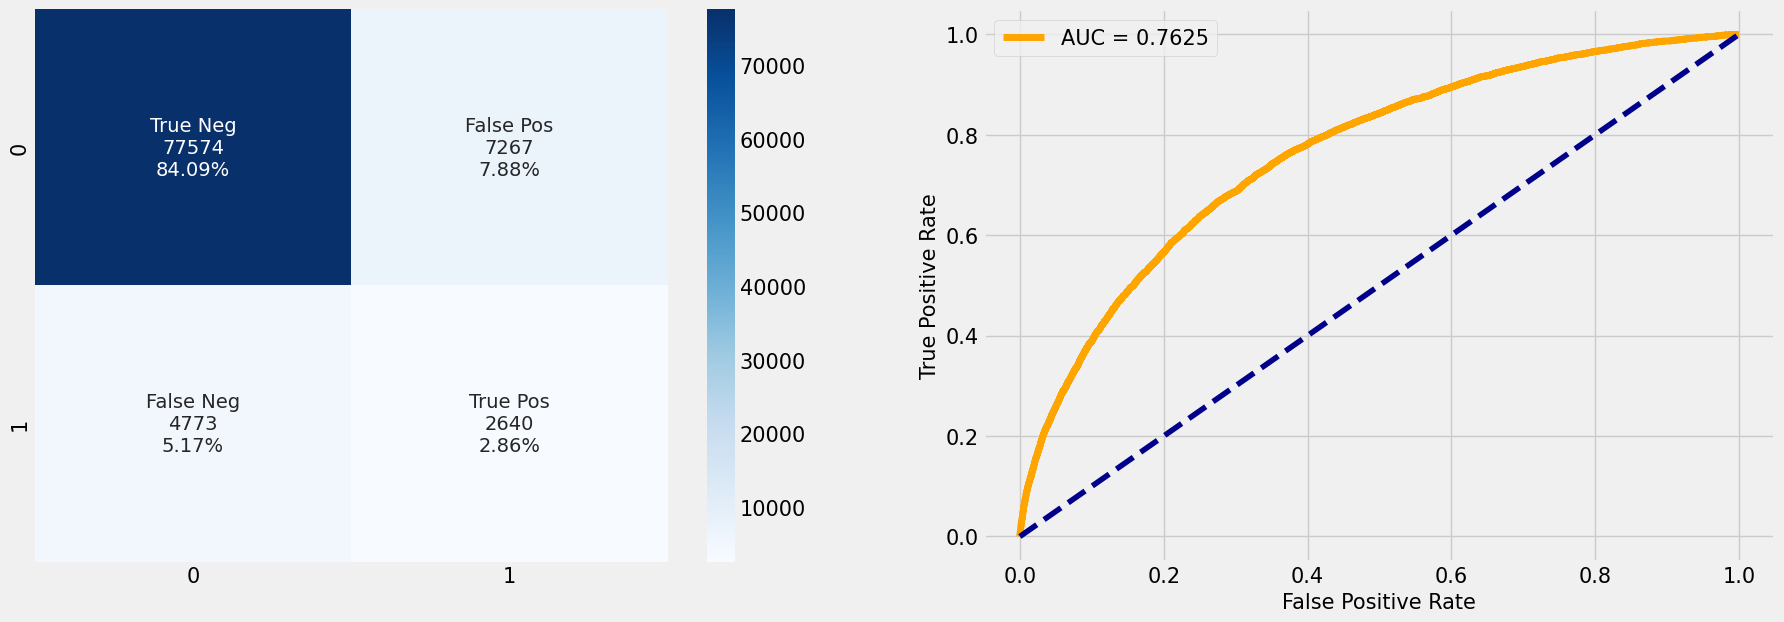

In [107]:
# XGBClassifier scale pos weight 5
train_model(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=5),final_data)

In [108]:
#Présentation des résultats
models_scale_pos_weight = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=3),
          LGBMClassifier(device='gpu',scale_pos_weight=3),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=3),
          CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=5),
          LGBMClassifier(device='gpu',scale_pos_weight=5),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=5)
        ]

In [109]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models_scale_pos_weight:
    start = time.time()
    final_data_light=final_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train,test=train_test_split(final_data_light,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    X_train=train.drop(["TARGET"],axis=1)
    X_test=test.drop(["TARGET"],axis=1)
    y_train=train[["TARGET"]]
    y_test=test[["TARGET"]]
    
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 2min 57s
Wall time: 1min 10s


In [110]:
base_models

Model       AUC  Accuracy Precision    Recall        F1  \
3  CatBoostClassifier  0.777736  0.872103  0.281574  0.381357  0.323956   
0  CatBoostClassifier   0.77731  0.906508  0.360626   0.21152  0.266644   
4      LGBMClassifier   0.77625  0.865112   0.26886  0.394712  0.319851   
1      LGBMClassifier  0.776072  0.905045  0.354252  0.220828  0.272062   
2       XGBClassifier  0.763585  0.900872  0.327901  0.222582  0.265167   
5       XGBClassifier  0.762459  0.869491  0.266478  0.356131   0.30485   

        Time  
3  16.992299  
0  16.448041  
4  10.059992  
1   9.614727  
2   8.230987  
5   9.089757

### Vérification des base models avec les données SMOTE : 

In [30]:
def train_model_smote(model,data,X_train_smote,y_train_smote):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #train and test
    X_train=X_train_smote
    X_test=test.drop(["TARGET"],axis=1)
    y_train=y_train_smote
    y_test=test[["TARGET"]]
    
    
    with mlflow.start_run():
        
        trained_model=model.fit(X_train, y_train)
        predicted_qualities=trained_model.predict(X_test)
    
        #Evaluation metrics
        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        accuracy=accuracy_score(y_test, predicted_qualities)
        precision=precision_score(y_test,predicted_qualities)
        recall=recall_score(y_test,predicted_qualities)
        f_one=metrics.f1_score(y_test,predicted_qualities,average='weighted')
        
        #print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)
        
     
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("F-1 score",f_one)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(model,"model")

 RMSE: 0.2831430125041936
 MAE:0.08016996552994993
 R2:-0.08488156434054117
 Accuracy: 0.9198300344700501
 Precision:0.5223097112860893
 Recall:0.02684473222716849
 F-1 Score: 0.8852591670076239
AUC : 0.7634
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.52      0.03      0.05      7413

    accuracy                           0.92     92254
   macro avg       0.72      0.51      0.50     92254
weighted avg       0.89      0.92      0.89     92254



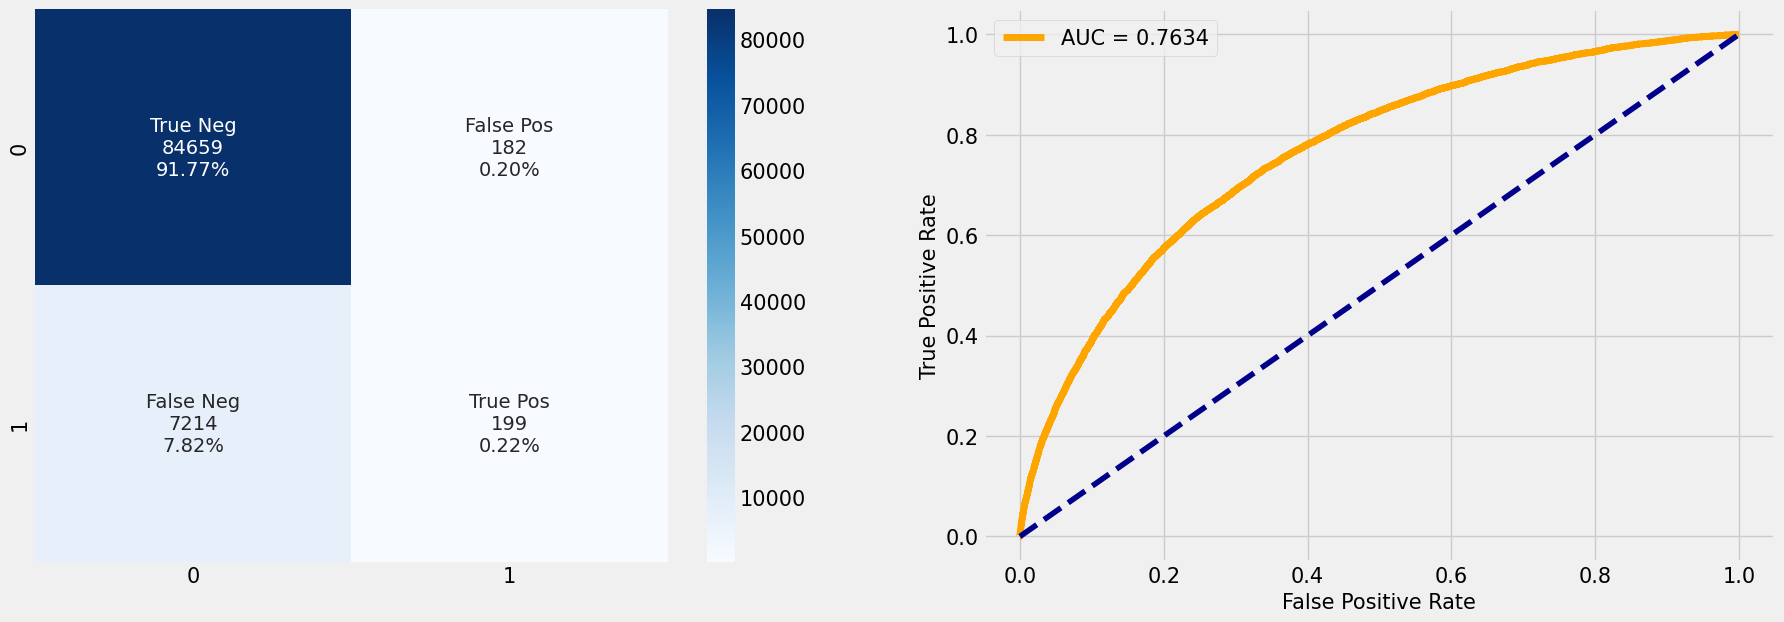

In [31]:
train_model_smote(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data,X_train_smote,y_train_smote)

 RMSE: 0.28421292243628027
 MAE:0.08077698527977106
 R2:-0.09309591907324388
 Accuracy: 0.9192230147202289
 Precision:0.4421364985163205
 Recall:0.020099824632402535
 F-1 Score: 0.8839638556481807
AUC : 0.7529
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.44      0.02      0.04      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.51      0.50     92254
weighted avg       0.88      0.92      0.88     92254



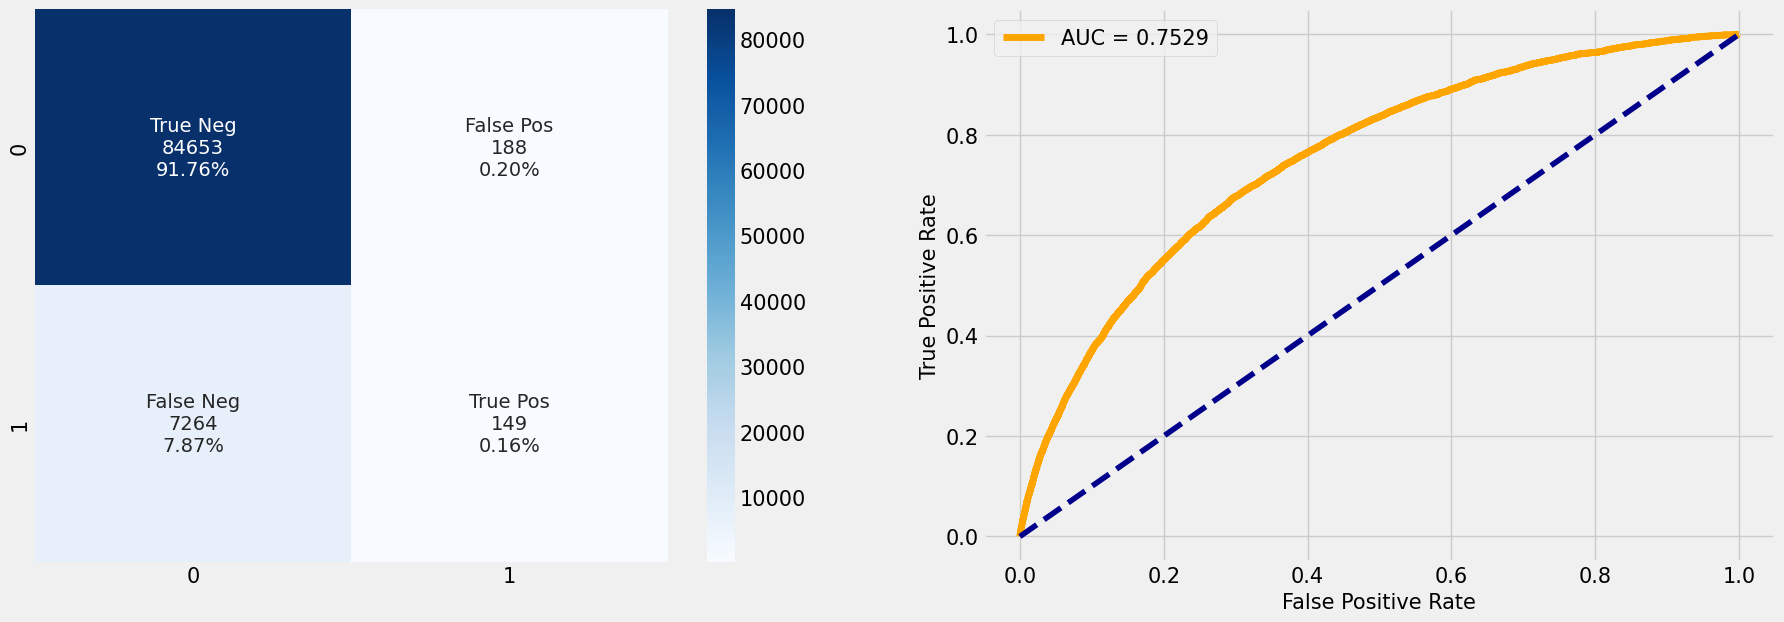

In [34]:
light_boost=LGBMClassifier(device='gpu')
train_model_smote(light_boost,final_data_light,X_train_smote,y_train_smote)

 RMSE: 0.2858102778146769
 MAE:0.08168751490450278
 R2:-0.10541745117229828
 Accuracy: 0.9183124850954972
 Precision:0.43322475570032576
 Recall:0.053824362606232294
 F-1 Score: 0.888001199303183
AUC : 0.7536
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.43      0.05      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.52      0.53     92254
weighted avg       0.88      0.92      0.89     92254



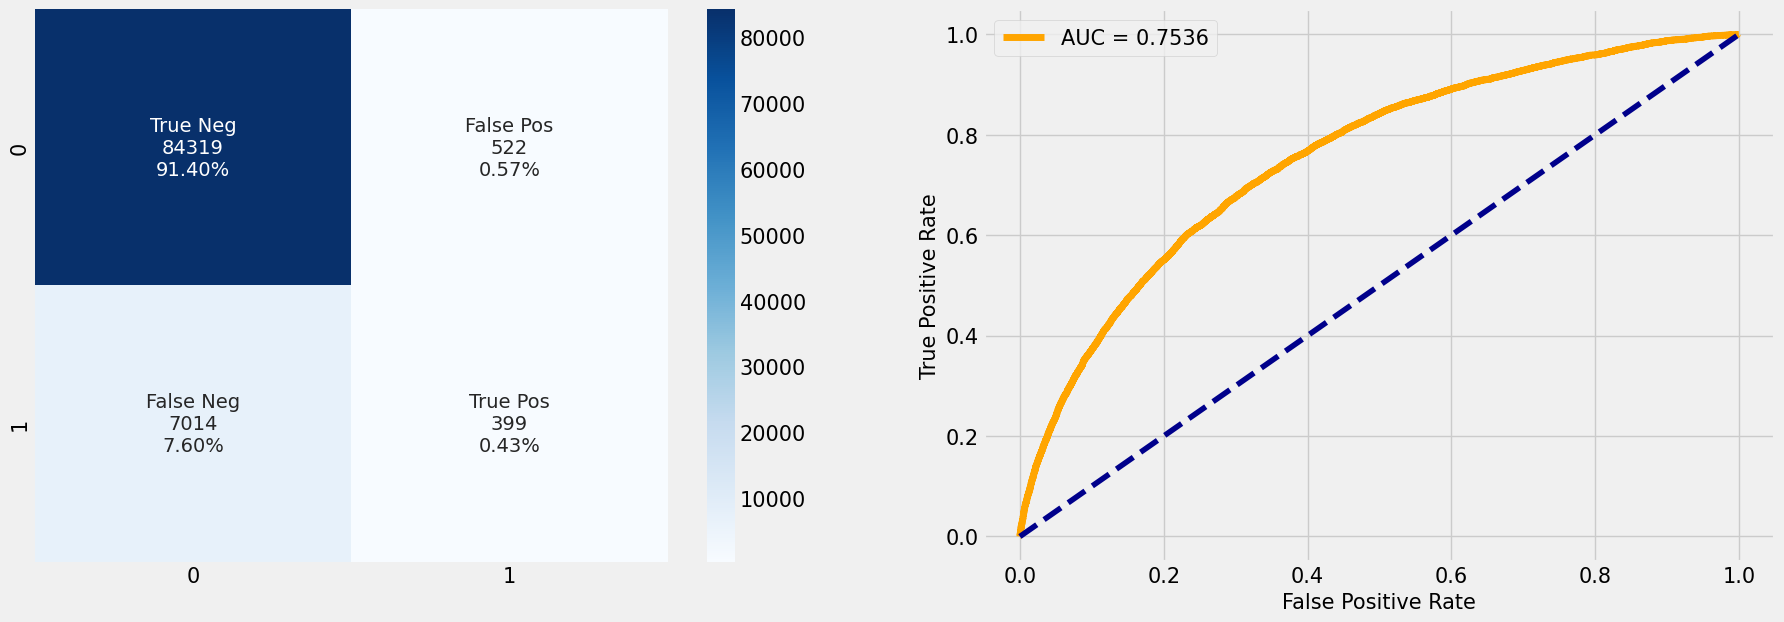

In [35]:
train_model_smote(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data,X_train_smote,y_train_smote)

In [40]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_smote, X_test, y_train_smote, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 3min 17s
Wall time: 1min 59s


In [41]:
models_res

Model       AUC  Accuracy Precision    Recall        F1  \
0  CatBoostClassifier   0.76337   0.91983   0.52231  0.026845  0.885259   
2       XGBClassifier  0.753557  0.918312  0.433225  0.053824  0.888001   
1      LGBMClassifier  0.752946  0.919223  0.442136    0.0201  0.883964   

        Time  
0  98.762752  
2   9.989336  
1  10.907327

In [42]:
mlflow.end_run()

**Conclusion:** Le Catboost et le XGBCLassifier semblent plus performants avec les données SMOTE cependant le LightGBM reste raisonnable pour les 2 types de données.



# 6. Features Selection - Recursive Feature Elimination 

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [43]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 312 features.
Fitting estimator with 307 features.
Fitting estimator with 302 features.
Fitting estimator with 297 features.
Fitting estimator with 292 features.
Fitting estimator with 287 features.
Fitting estimator with 282 features.
Fitting estimator with 277 features.
Fitting estimator with 272 features.
Fitting estimator with 267 features.
Fitting estimator with 262 features.
Fitting estimator with 257 features.
Fitting estimator with 252 features.
Fitting estimator with 247 features.
Fitting estimator with 242 features.
Fitting estimator with 237 features.
Fitting estimator with 232 features.
Fitting estimator with 227 features.
Fitting estimator with 222 features.
Fitting estimator with 217 features.
Fitting estimator with 212 features.
Fitting estimator with 207 features.
Fitting estimator with 202 features.
Fitting estimator with 197 features.
Fitting estimator with 192 features.
Fitting estimator with 187 features.
Time Elapsed: 1345.3278102874756
CPU t

In [44]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 182
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True False
 False  True False  True False  True  True  True]
Feature Ranking : [1 1 1 1 1 1 1 1 1 1 1 7 7 1 7 1 3 1 1 1]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1 : 

In [45]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

182
['CNT_CHILDREN', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM', 'PREV_APPL_MEAN_CARD_MEAN_SK_DPD', 'PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF', 'PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 'PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 'PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT', 'PREV_APPL

In [76]:
def cf_matrix_roc_auc(model,X_data,y_true, y_pred, y_pred_proba, feature_importances,roc_auc):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances :
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

    features = []
    for i in range(20):
        features.append(X_data.columns[np.argsort(model.feature_importances_)[::-1][i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[np.argsort(model.feature_importances_)[::-1][range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    show()

In [47]:
rfecv.cv_results_

{'mean_test_score': array([0.64782878, 0.67117896, 0.75009971, 0.75597659, 0.75915974,
        0.76124184, 0.76268736, 0.76366251, 0.76417511, 0.76431011,
        0.76666614, 0.7679737 , 0.76901064, 0.77014322, 0.77009485,
        0.77031549, 0.77039598, 0.77049647, 0.77049078, 0.77095066,
        0.77055204, 0.77078227, 0.77113706, 0.77095677, 0.77064787,
        0.77139367, 0.77129754, 0.7710637 , 0.77127938, 0.77080076,
        0.77063015, 0.77089724, 0.77117261, 0.77088163, 0.77105478,
        0.77097353, 0.77128741, 0.77156541, 0.77102579, 0.77085253,
        0.77072431, 0.77089195, 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ]),
 'std_test_score': array([0.03597192, 0.00657161, 0.00350897, 0.00279732, 0.00230942,
        0.00236446, 0

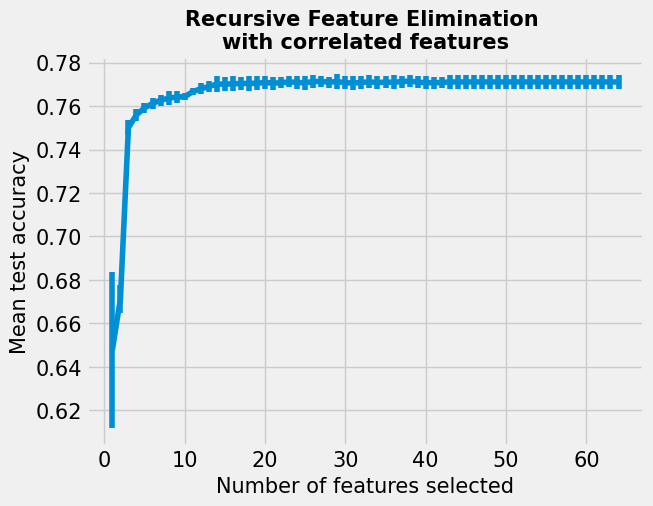

In [48]:
#Plot number of features vs CV scores
import matplotlib.pyplot as plt

min_features_to_select = 1  
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [49]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 182)

### Sauvegarde de X_data

In [50]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [51]:
X_data.shape

(307511, 183)

In [52]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('X_data.zip', index=True, compression=compression_opts)

CPU times: total: 1min 4s
Wall time: 1min 12s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 182 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [53]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('X_sample.zip', index=True, compression=compression_opts)

CPU times: total: 6.59 s
Wall time: 8.18 s


In [54]:
%%time
X_data.sample(10000).to_csv('X_sample.csv', index=True)

CPU times: total: 1.27 s
Wall time: 1.92 s


## Transforming Data

In [55]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [56]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

## Model evaluation

In [57]:
mlflow.set_experiment('Recursive_feature_selection_experiments')

2023/08/04 07:20:11 INFO mlflow.tracking.fluent: Experiment with name 'Recursive_feature_selection_experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/kherm/mlruns/659634954043103438', creation_time=1691126411887, experiment_id='659634954043103438', last_update_time=1691126411887, lifecycle_stage='active', name='Recursive_feature_selection_experiments', tags={}>

In [70]:
def train_model_rfe(model,data,X_data,X_train_selected,X_test_selected,y_train,y_test):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #train and test
    X_train=X_train_selected
    X_test=X_test_selected
    y_train=y_train
    y_test=y_test
    
    
    with mlflow.start_run():
        
        trained_model=model.fit(X_train, y_train)
        predicted_qualities=trained_model.predict(X_test)
    
        #Evaluation metrics
        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        accuracy=accuracy_score(y_test, predicted_qualities)
        precision=precision_score(y_test,predicted_qualities)
        recall=recall_score(y_test,predicted_qualities)
        f_one=metrics.f1_score(y_test,predicted_qualities,average='weighted')
        
        #print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model,X_data, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)
        
     
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("F-1 score",f_one)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(model,"model")

 RMSE: 0.28251063247794944
 MAE:0.07981225746309104
 R2:-0.080040962444484
 Accuracy: 0.9201877425369089
 Precision:0.5615763546798029
 Recall:0.03075677863213274
 F-1 Score: 0.8860084165559494
AUC : 0.7754
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.56      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



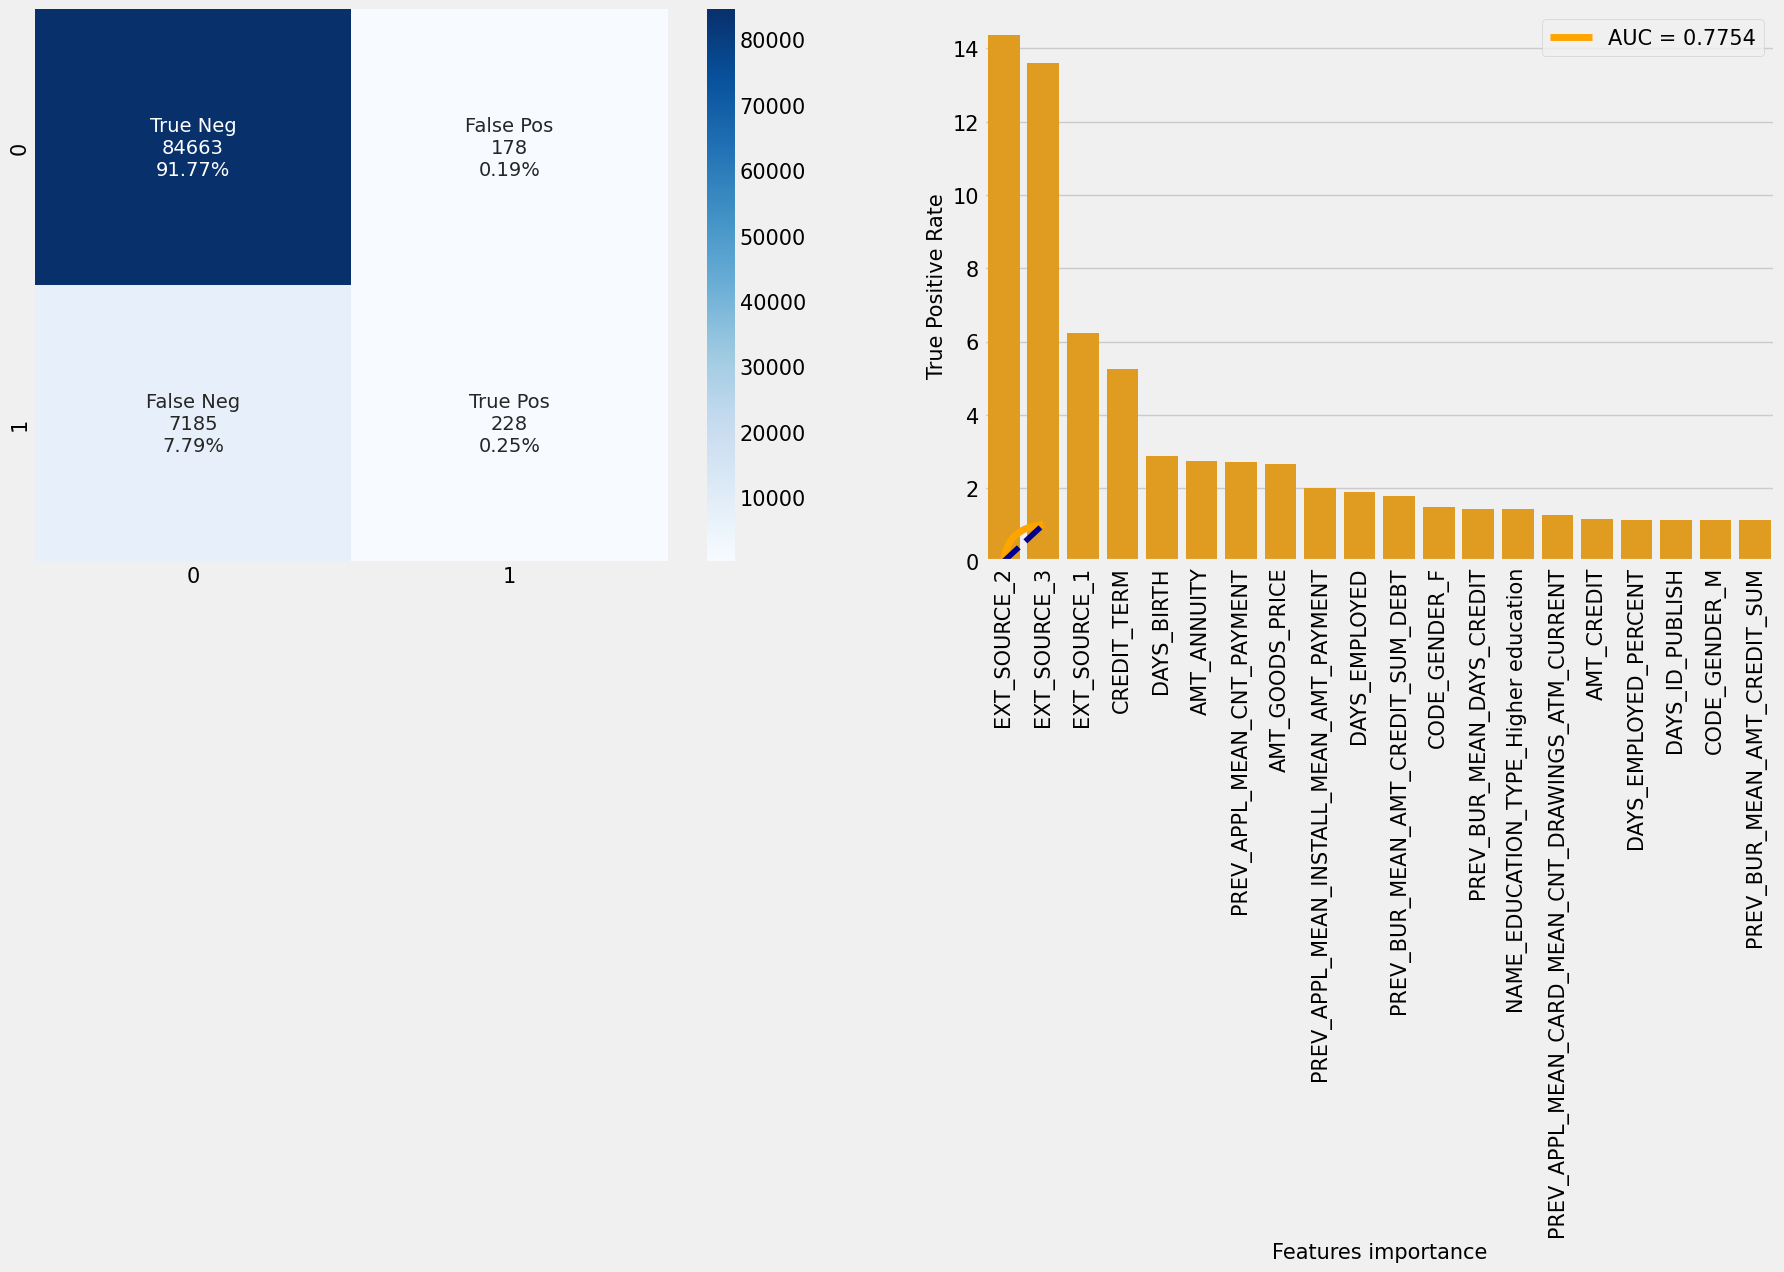

In [77]:
train_model_rfe(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

 RMSE: 0.2827790876294538
 MAE:0.07996401240054632
 R2:-0.08209455112765984
 Accuracy: 0.9200359875994537
 Precision:0.5416666666666666
 Recall:0.03156616754350466
 F-1 Score: 0.8860372789391506
AUC : 0.7740
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.54      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



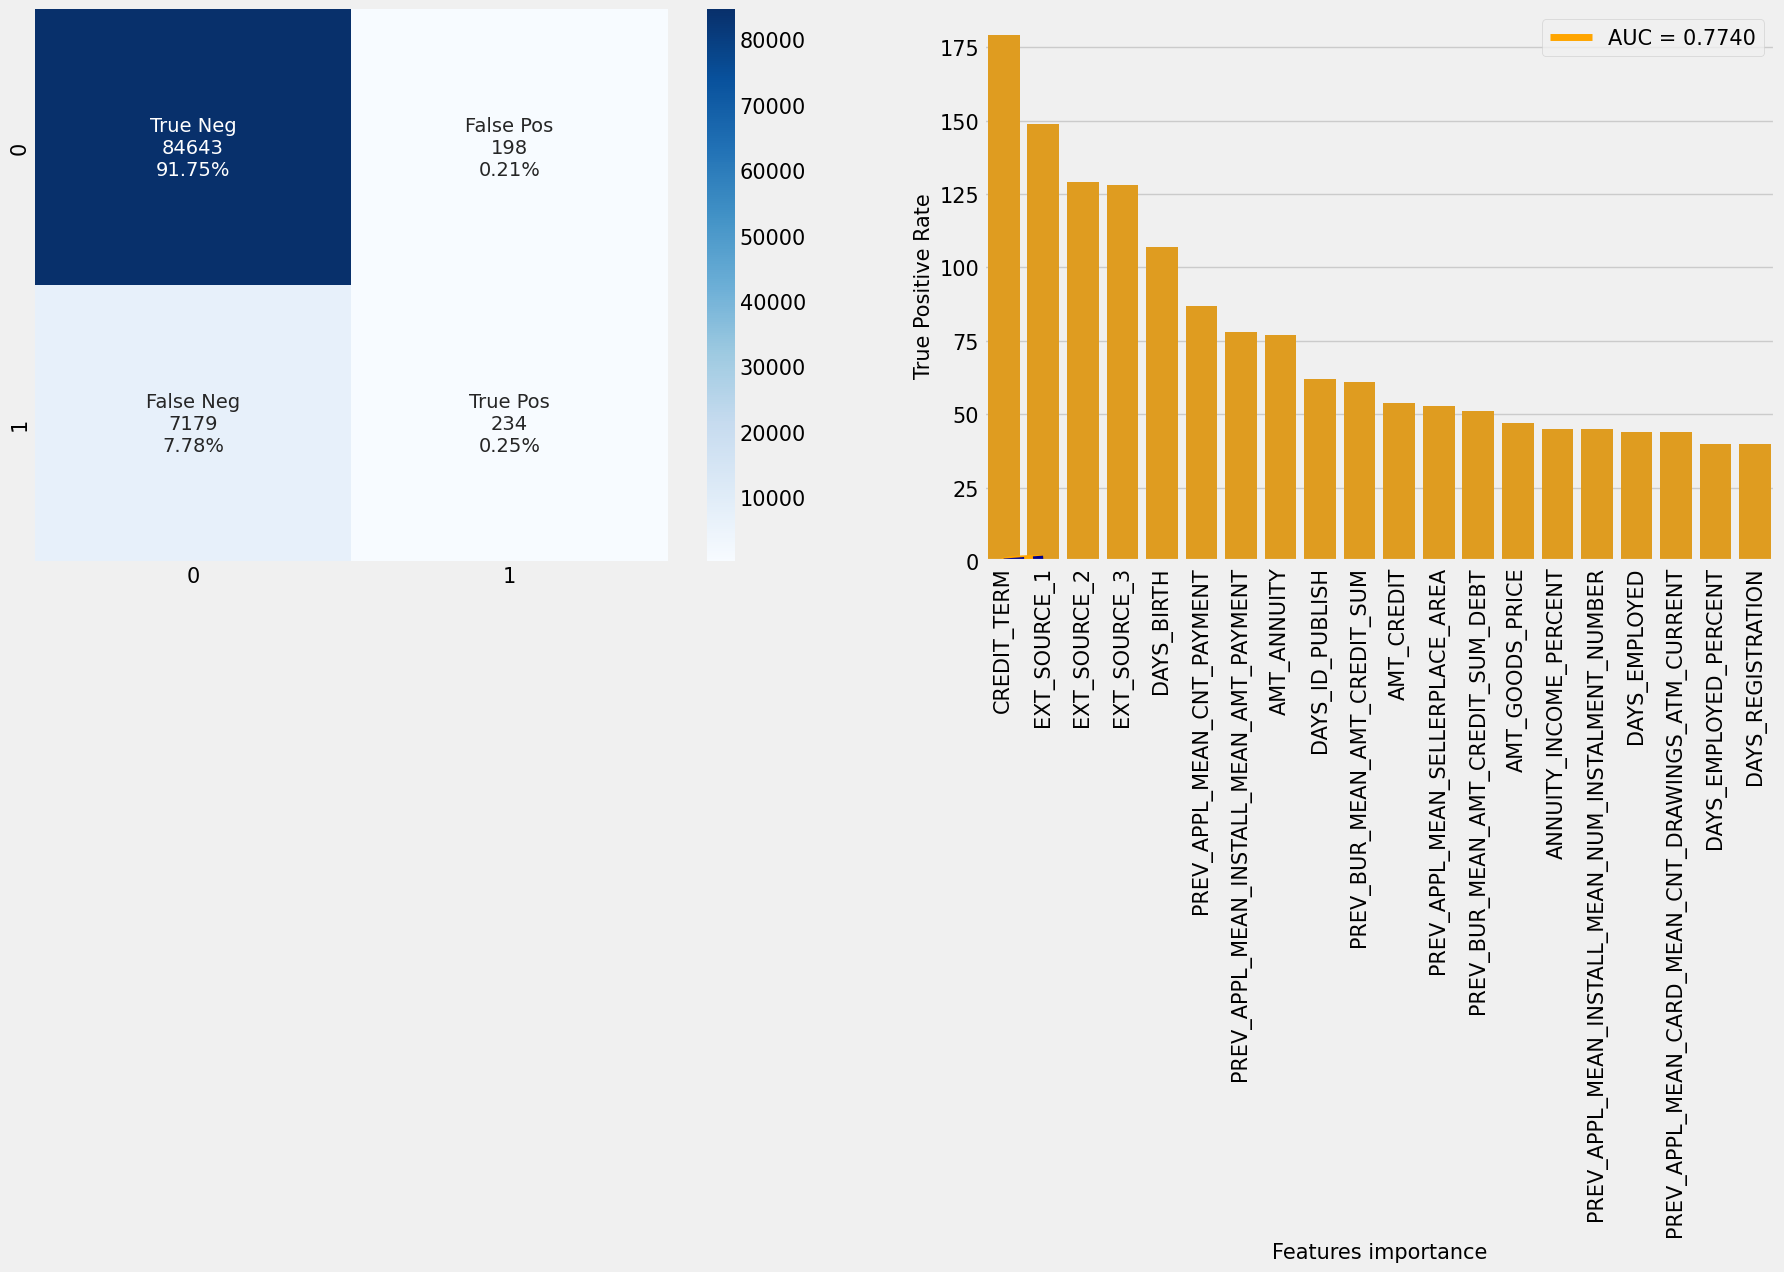

In [78]:
train_model_rfe(LGBMClassifier(device='gpu'),final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

 RMSE: 0.28499370248085704
 MAE:0.08122141045374727
 R2:-0.09911000021682992
 Accuracy: 0.9187785895462527
 Precision:0.45555555555555555
 Recall:0.0553082422770808
 F-1 Score: 0.8884624160816502
AUC : 0.7647
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.46      0.06      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.69      0.52      0.53     92254
weighted avg       0.89      0.92      0.89     92254



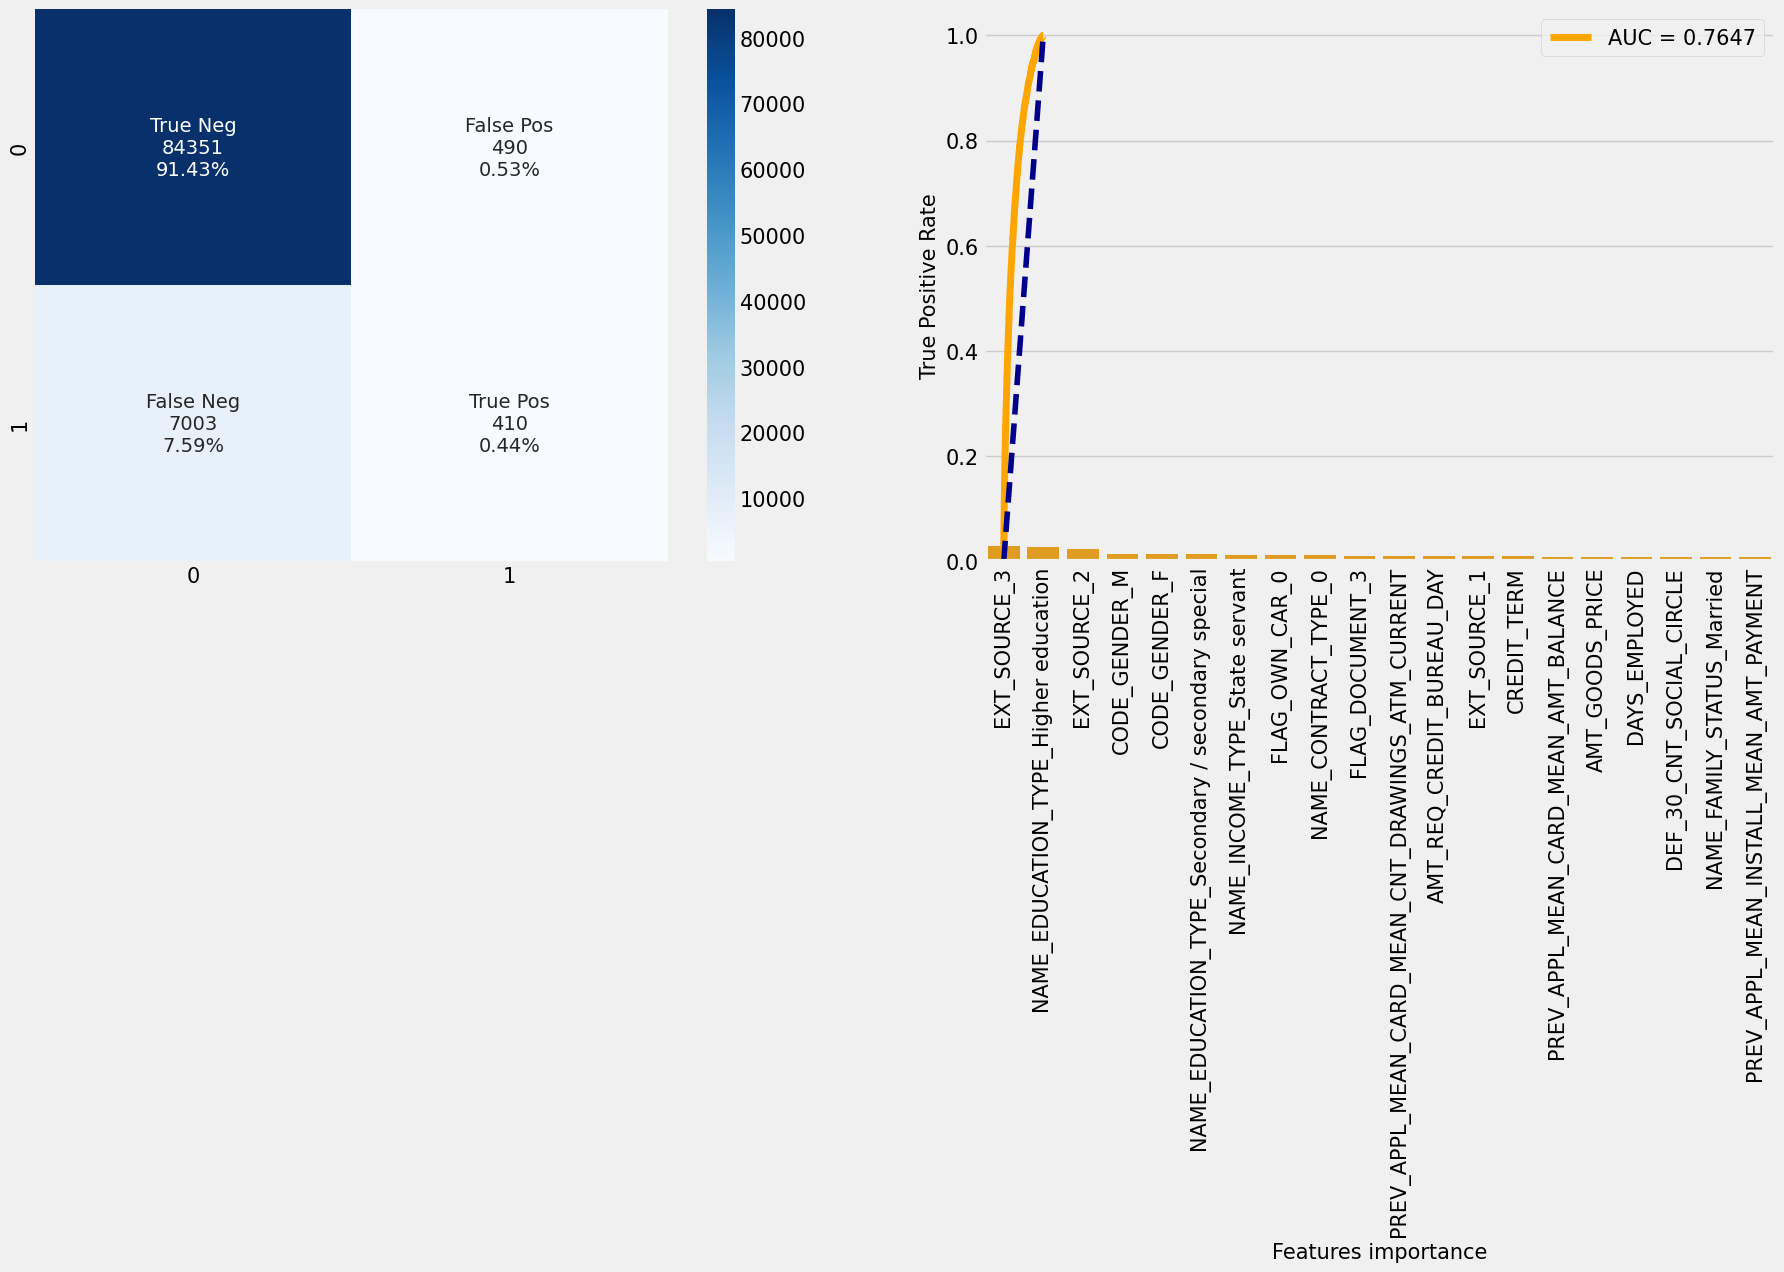

In [79]:
train_model_rfe(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

In [83]:
mlflow.end_run()

In [80]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: total: 1min 5s
Wall time: 25.4 s


In [81]:
#Models performance with features selection
models_rfe

Model       AUC  Accuracy Precision    Recall        F1  \
0  CatBoostClassifier  0.775153  0.920274  0.571782  0.031161  0.059102   
1      LGBMClassifier  0.773984  0.920036  0.541667  0.031566  0.059656   
2       XGBClassifier  0.764657  0.918779  0.455556  0.055308  0.098641   

        Time  
0  14.617299  
1   6.633967  
2   4.121959

**Conclusion**: 
LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time. CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

On développera maintenant La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation. 

# 7. La fonction coût

La problématique est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte. 

Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP (où FN = nombre de FN dans la matrice de confusion pour un seuil donné, FP = nombre de FP) et de trouver son minimum pour un seuil donné.

On peut se fixer l'hypothèse d'un Beta = 10. Vérifions-le avec une étape de tests fonctionnels.

In [84]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 10
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : -1.380952380952381
############################
Test 1 : [500, 300, 30, 10]
Score : -1.5821596244131455
############################
Test 2 : [400, 300, 70, 50]
Score : -1.0276497695852536
############################
Test 3 : [400, 300, 50, 70]
Score : -0.8723404255319149
############################
Test 4 : [350, 250, 80, 120]
Score : -0.43656716417910424
############################
Test 5 : [350, 250, 180, 90]
Score : -0.5524193548387097


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [85]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [86]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

# 8. Hyperparameters tunning - Hyperopt et AUC score

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score et le custom score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [87]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [93]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [94]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [95]:
%%time
SEED=1
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(SEED), algo=tpe.suggest)


100%|██████████| 30/30 [23:02<00:00, 46.09s/trial, best loss: 0.9771566131518332]
CPU times: total: 1h 49min 57s
Wall time: 23min 2s


In [96]:
mlflow.set_experiment('Optimized_lightboost_with_rfe_and_custom_score')

2023/08/04 08:31:27 INFO mlflow.tracking.fluent: Experiment with name 'Optimized_lightboost_with_rfe_and_custom_score' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/kherm/mlruns/542715115735681873', creation_time=1691130687287, experiment_id='542715115735681873', last_update_time=1691130687287, lifecycle_stage='active', name='Optimized_lightboost_with_rfe_and_custom_score', tags={}>

In [97]:
def train_model_optimized(model,data,X_data,X_train_selected,X_test_selected,y_train,y_test):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #train and test
    X_train=X_train_selected
    X_test=X_test_selected
    y_train=y_train
    y_test=y_test
    
    
    with mlflow.start_run():
        
        trained_model=model.fit(X_train, y_train)
        predicted_qualities=trained_model.predict(X_test)
    
        #Evaluation metrics
        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        accuracy=accuracy_score(y_test, predicted_qualities)
        precision=precision_score(y_test,predicted_qualities)
        recall=recall_score(y_test,predicted_qualities)
        f_one=metrics.f1_score(y_test,predicted_qualities,average='weighted')
        
        #print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model,X_data, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)
        
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("F-1 score",f_one)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(model,"model")

In [98]:
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

 RMSE: 0.2824914473478823
 MAE:0.07980141782470136
 R2:-0.07989427753854295
 Accuracy: 0.9201985821752986
 Precision:0.5652173913043478
 Recall:0.029812491568865507
 F-1 Score: 0.8858817299012713
AUC : 0.7785
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.57      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



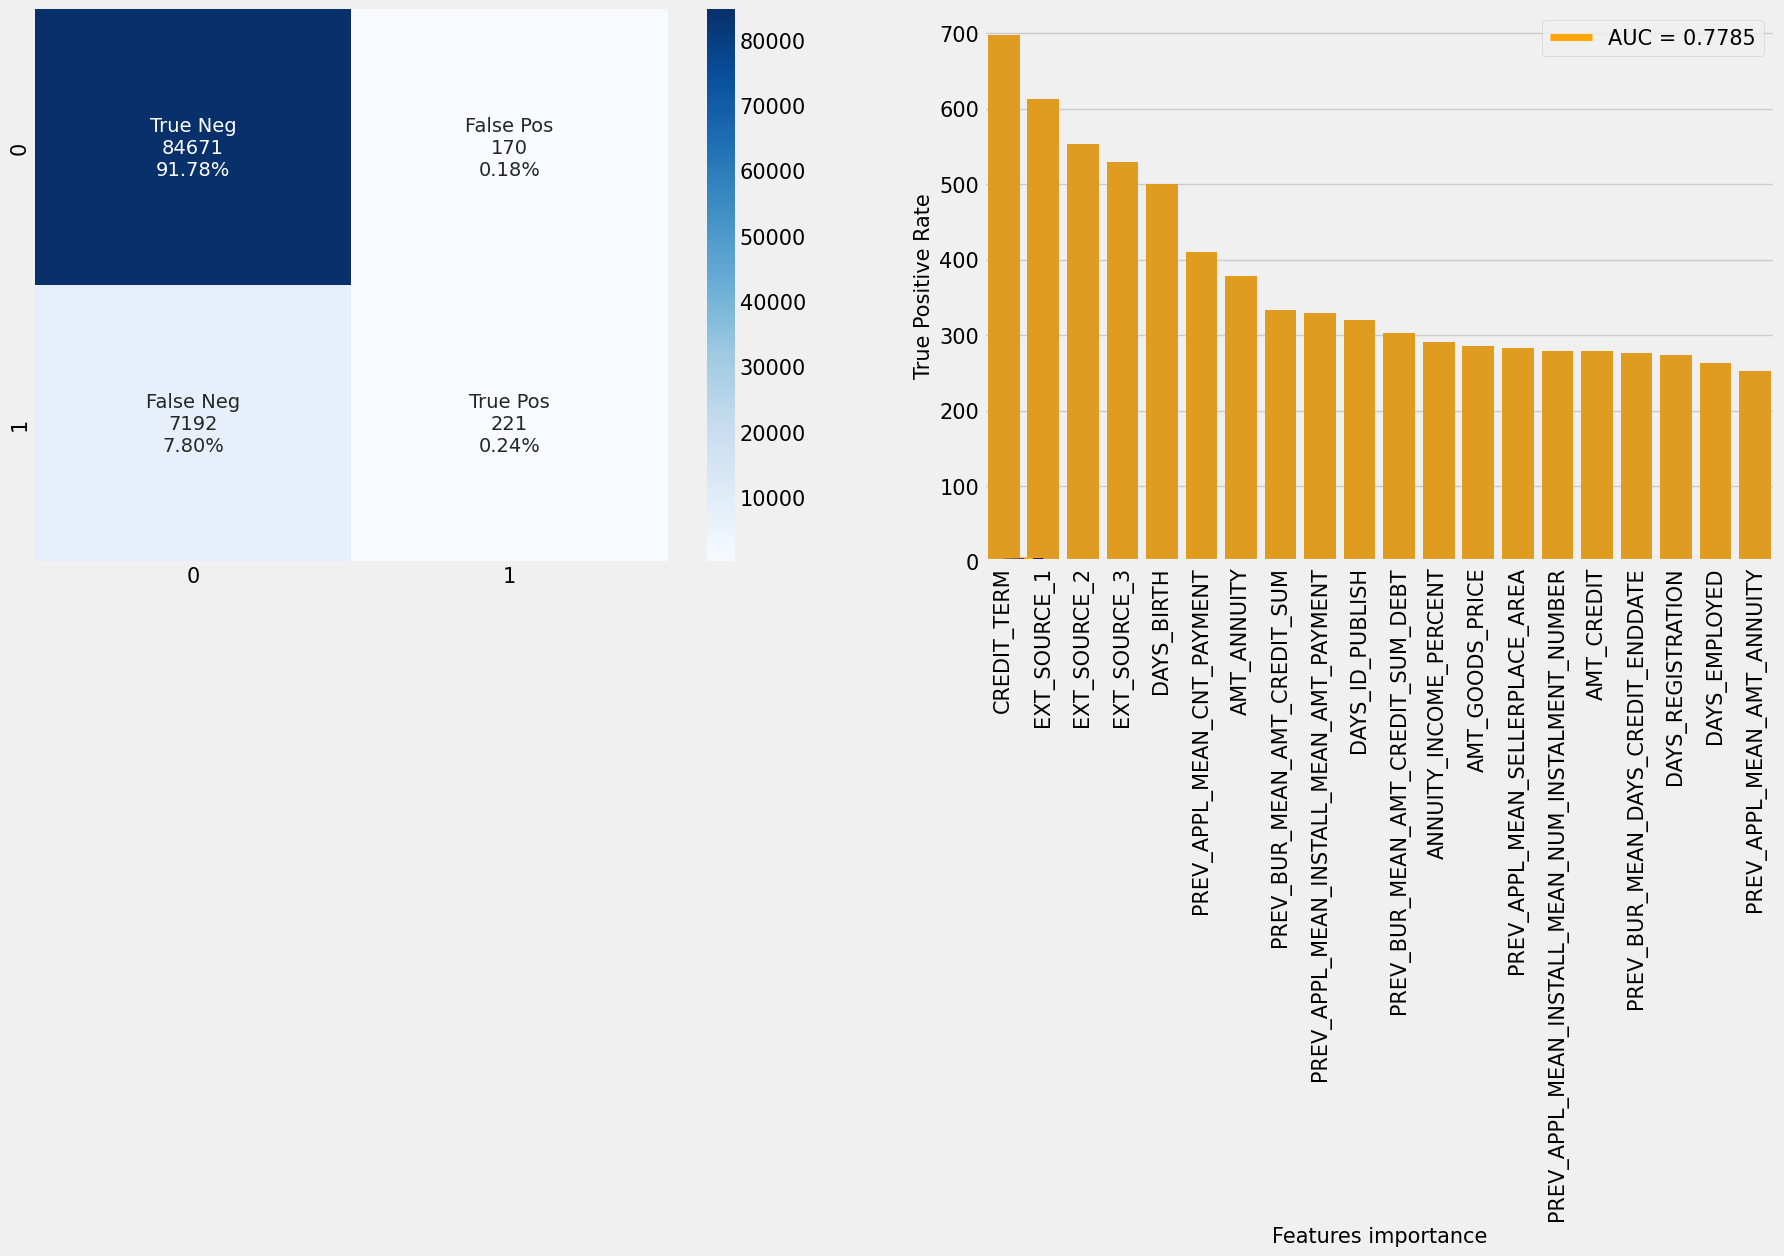

In [99]:
train_model_optimized(lgbm,final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

In [100]:
%%time

lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("LGBMClassifier.pkl", "wb"))


CPU times: total: 1min 6s
Wall time: 13.9 s


In [101]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.778535


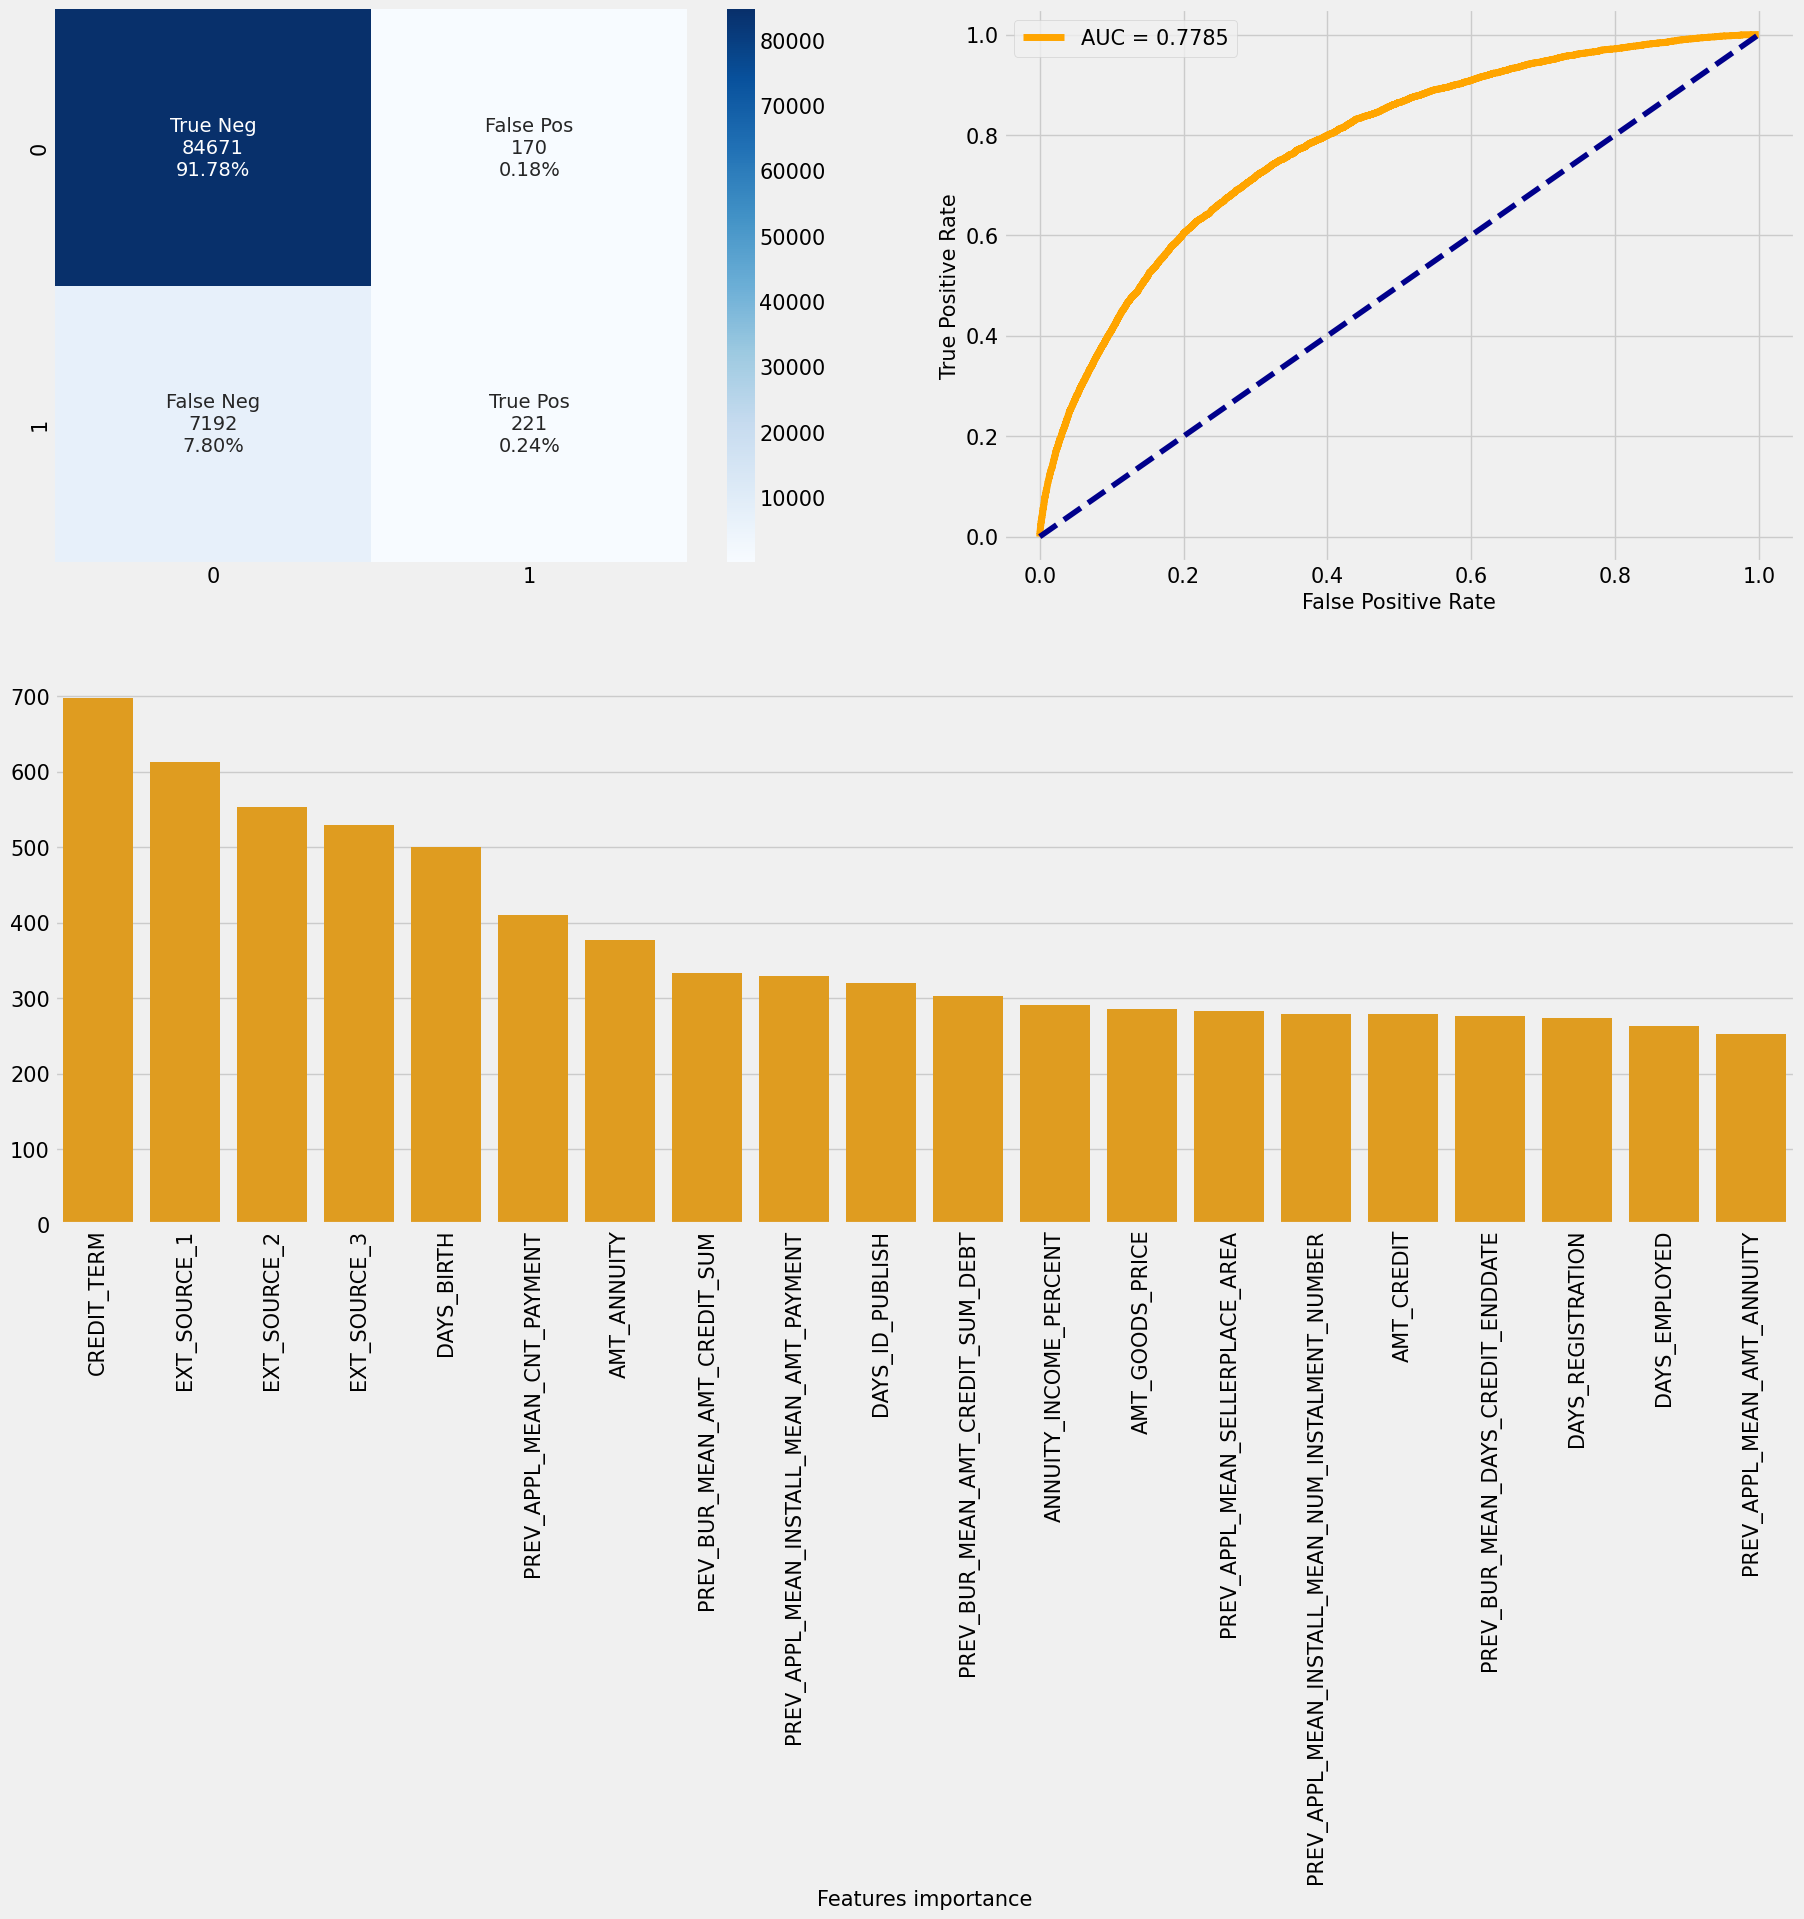

In [103]:
cf_matrix_roc_auc(lgbm, X_data, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True,roc_auc=roc_auc)

In [104]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.18%
False Neg: 7.80%


(0.0018427385262427644, 0.07795867929845861)

In [105]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 697]
['EXT_SOURCE_1', 613]
['EXT_SOURCE_2', 553]
['EXT_SOURCE_3', 529]
['DAYS_BIRTH', 500]
['PREV_APPL_MEAN_CNT_PAYMENT', 410]
['AMT_ANNUITY', 377]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 333]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 329]
['DAYS_ID_PUBLISH', 320]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 303]
['ANNUITY_INCOME_PERCENT', 291]
['AMT_GOODS_PRICE', 286]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 283]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 279]
['AMT_CREDIT', 279]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 276]
['DAYS_REGISTRATION', 274]
['DAYS_EMPLOYED', 263]
['PREV_APPL_MEAN_AMT_ANNUITY', 253]
['PREV_BUR_MEAN_DAYS_CREDIT', 245]
['DAYS_EMPLOYED_PERCENT', 243]
['DAYS_LAST_PHONE_CHANGE', 228]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 225]
['CREDIT_INCOME_PERCENT', 225]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 215]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 212]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 202]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 192]
['PREV_BU

In [106]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'}
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [107]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(SEED), algo=tpe.suggest)

100%|██████████| 30/30 [26:01<00:00, 52.07s/trial, best loss: 0.22291592043294117]
CPU times: total: 2h 5min 22s
Wall time: 26min 1s


In [108]:
lgbm_2 = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')


 RMSE: 0.28224192198473236
 MAE:0.07966050252563575
 R2:-0.07798737376130838
 Accuracy: 0.9203394974743643
 Precision:0.5666666666666667
 Recall:0.03669229731552678
 F-1 Score: 0.8869172021298004
AUC : 0.7809
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.57      0.04      0.07      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.52      0.51     92254
weighted avg       0.89      0.92      0.89     92254



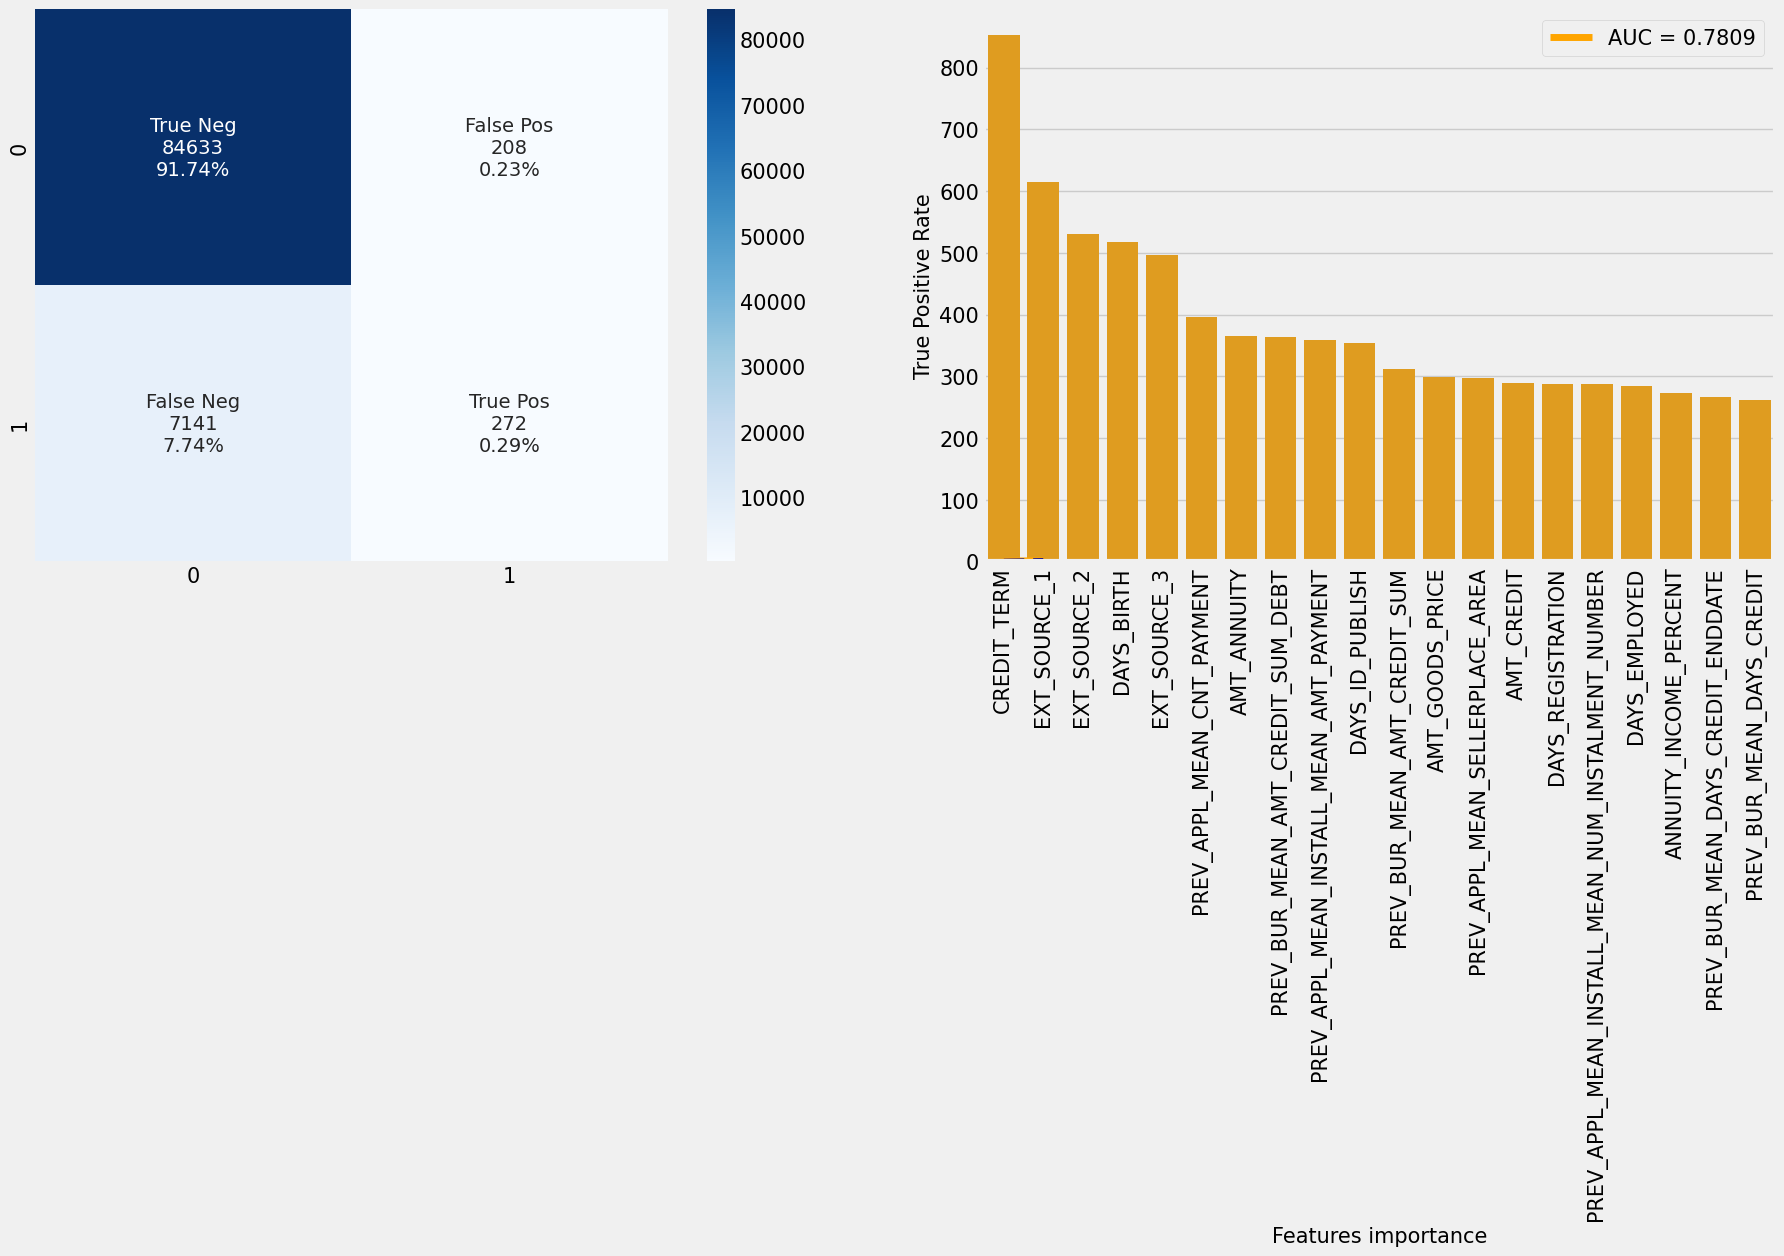

In [109]:
train_model_optimized(lgbm_2,final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

In [110]:
mlflow.end_run()

In [111]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)

CPU times: total: 1min 30s
Wall time: 19.8 s


LGBMClassifier(colsample_bytree=0.600170715692459, device='gpu',
               learning_rate=0.02975841167356727, max_depth=7, n_estimators=600,
               reg_lambda=2.156064880286573, subsample=0.629809210489369)

In [112]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.780907


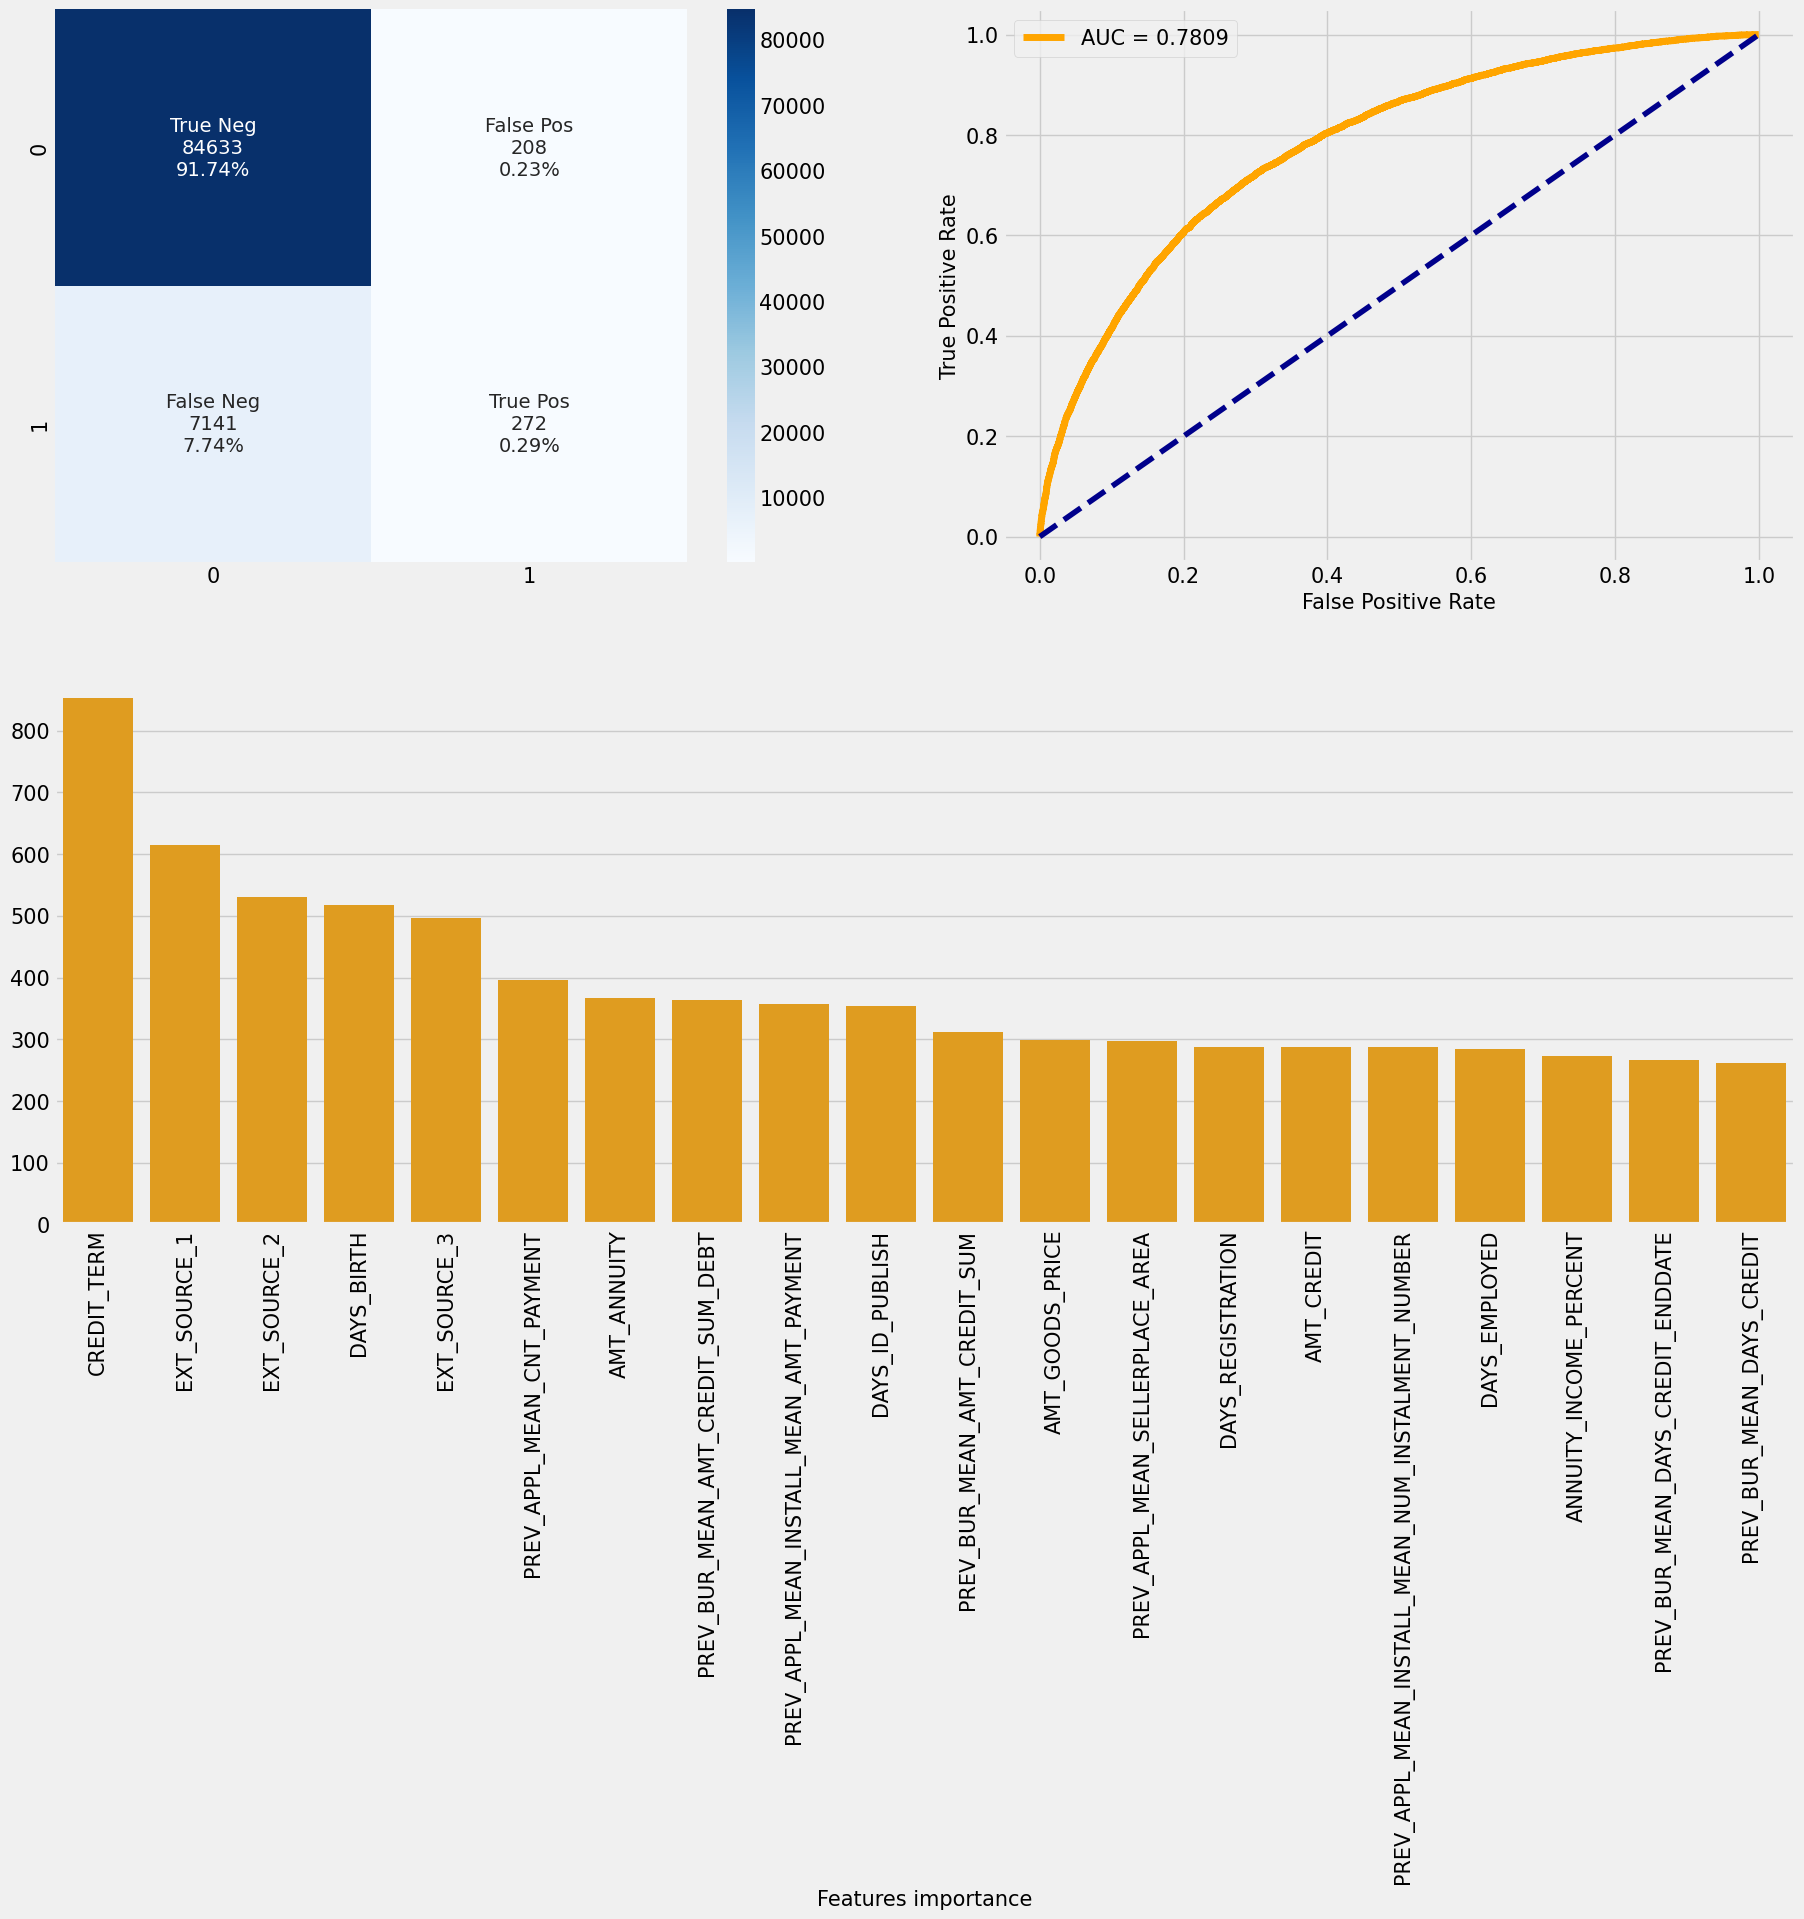

In [113]:
cf_matrix_roc_auc(lgbm,X_data, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True,roc_auc=roc_auc)

In [114]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.23%
False Neg: 7.74%


(0.002254644785049971, 0.07740585774058577)

In [115]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 852]
['EXT_SOURCE_1', 615]
['EXT_SOURCE_2', 530]
['DAYS_BIRTH', 518]
['EXT_SOURCE_3', 497]
['PREV_APPL_MEAN_CNT_PAYMENT', 396]
['AMT_ANNUITY', 367]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 363]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 357]
['DAYS_ID_PUBLISH', 354]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 312]
['AMT_GOODS_PRICE', 298]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 297]
['DAYS_REGISTRATION', 288]
['AMT_CREDIT', 288]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 287]
['DAYS_EMPLOYED', 285]
['ANNUITY_INCOME_PERCENT', 273]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 266]
['PREV_BUR_MEAN_DAYS_CREDIT', 262]
['PREV_APPL_MEAN_AMT_ANNUITY', 256]
['DAYS_EMPLOYED_PERCENT', 250]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 228]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 227]
['CREDIT_INCOME_PERCENT', 220]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 215]
['DAYS_LAST_PHONE_CHANGE', 214]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 199]
['PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 193]
['PREV_APPL_MEAN_D

In [118]:
X_data

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002               0.0          0.001512    0.090287     0.090032   
100003               0.0          0.002089    0.311736     0.132924   
100004               0.0          0.000358    0.022472     0.020025   
100006               0.0          0.000935    0.066837     0.109477   
100007               0.0          0.000819    0.116854     0.078975   
...                  ...               ...         ...          ...   
456251               0.0          0.001127    0.052360     0.101176   
456252               0.0          0.000396    0.056067     0.040505   
456253               0.0          0.001089    0.157969     0.110618   
456254               0.0          0.001243    0.081175     0.072499   
456255               0.0          0.001127    0.157303     0.185258   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             0.077441                    0.256321    0.111161   
100003             0.271605                    0.045016    0.522886   
100004             0.023569                    0.134897    0.651466   
100006             0.063973                    0.107023    0.649154   
100007             0.117845                    0.392880    0.701409   
...                     ...                         ...         ...   
456251             0.046016                    0.446855    0.103608   
456252             0.046016                    0.344429    0.748929   
456253             0.135802                    0.065247    0.421477   
456254             0.069585                    0.069553    0.252086   
456255             0.158249                    0.635991    0.528016   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
SK_ID_CURR                                                     ...   
100002           0.964437           0.852140         0.705433  ...   
100003           0.933676           0.951929         0.959566  ...   
100004           0.987439           0.827335         0.648326  ...   
100006           0.830337           0.601451         0.661387  ...   
100007           0.830393           0.825268         0.519522  ...   
...                   ...                ...              ...  ...   
456251           0.986824           0.657263         0.724607  ...   
456252           0.907995           0.822147         0.431708  ...   
456253           0.557782           0.726937         0.284424  ...   
456254           0.732805           0.896158         0.870641  ...   
456255           0.929544           0.792153         0.943032  ...   

            ORGANIZATION_TYPE_Transport: type 3  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   
...                                         ...   
456251                                      0.0   
456252                                      0.0   
456253                                      0.0   
456254                                      0.0   
456255                                      0.0   

            ORGANIZATION_TYPE_Transport: type 4  \
SK_ID_CURR                                        
100002                                      0.0   
100003                                      0.0   
100004                                      0.0   
100006                                      0.0   
100007                                      0.0   
...                                         ...   
456251                                      0.0   
456252                                      0.0   
456253                                      0.0   
456254                      

# Conclusion
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 0.19% (contre 0.21%), les FN sont à 0.78% (contre 0.77%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

In [ ]:
# open mlflowruns in jupyter notebook home or in terminal with mlflow ui
#class weight = balance pour xgboost sans le smote 
#score personalisé qui pénalise le modèle plus quand un client ne paye pas
#Valeurs manquantes à tester plussieurs autres possibilités